In [1]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
import random as r
import math
import keras
import cv2


from PIL import Image
from keras import layers
from keras.models import Sequential
from keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.preprocessing import image
from keras.utils import np_utils, plot_model

import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
def get_files(file_dir, train_size):

    images = []   
    subfolders = []
    train_array = []
    test_array = []
    train_img_list = []
    test_img_list = []
    train_all_img = []
    test_all_img = []
 
    for dirPath, dirNames, fileNames in os.walk(file_dir):
        
        names = []
        for name in fileNames:
            names.append(os.path.join(dirPath, name))
        for name in dirNames:
            subfolders.append(os.path.join(dirPath, name))
        r.shuffle(names)
        if names != []:
            images.append(names)
    print(subfolders)
    mincount = float("Inf")
    for num_folder in subfolders:
        n_img = len(os.listdir(num_folder))
        
        if n_img < mincount:
            mincount = n_img

    for i in range(len(images)):
        #images[i] = images[i][0:mincount]
        #images[i] = images[i]
        print(len(images[i]))
        train_img_list.append([])
        test_img_list.append([])
        train_num = math.ceil(len(images[i]) * train_size)
        train_img_list[i] = images[i][0:train_num]
        test_img_list[i] = images[i][train_num:]

    for i in range(len(images)):
        train_all_img.extend(train_img_list[i])

    for i in range(len(images)):
        test_all_img.extend(test_img_list[i])

    train_labels = []
    test_labels = []
    for count in range(len(subfolders)):
        train_labels = np.append(train_labels, len(train_img_list[count]) * [count])
        #print(len(train_labels))
    for count in range(len(subfolders)):
        test_labels = np.append(test_labels, len(test_img_list[count]) * [count])
            
    train_array = np.array([train_all_img, train_labels])
    train_array = train_array[:, np.random.permutation(train_array.shape[1])].T
    test_array = np.array([test_all_img, test_labels])
    test_array = test_array[:, np.random.permutation(test_array.shape[1])].T
    
    train_img = list(train_array[:, 0])
    train_labels = list(train_array[:, 1])
    train_labels = [int(float(i)) for i in train_labels]
    
    test_img = list(test_array[:, 0])
    test_labels = list(test_array[:, 1])
    test_labels = [int(float(i)) for i in test_labels]
    
    # 返回图片路径列表和对应标签列表
    return train_img, train_labels, test_img, test_labels

In [3]:
model = Sequential()
#卷積層1
model.add(Conv2D(filters=63,
                 kernel_size=(3,3),
                 padding='same',
                 input_shape=(9,7,1), 
                 activation='relu', name = "conv_1"))
model.add(BatchNormalization(name = "bn_1"))
model.add(Dropout(0.25, name = "DP1"))
#卷積層2
model.add(Conv2D(filters=126,
                 kernel_size=(3,3),
                 padding='same',
                 activation='relu', name = "conv_2"))
model.add(BatchNormalization(name = "bn_2"))
model.add(Dropout(0.25, name = "DP2"))
#卷積層3
model.add(Conv2D(filters=252,
                 kernel_size=(3,3),
                 padding='same',
                 activation='relu', name = "conv_3"))
model.add(BatchNormalization(name = "bn_3"))

model.add(Dropout(0.25, name = "DP3"))
#平坦層
model.add(Flatten(name = "Flat"))
#全連接層
model.add(Dense(504, activation='relu', name = "dense_1"))
#輸出層
model.add(Dense(5,activation='softmax', name = "dense_2"))

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 9, 7, 63)          630       
_________________________________________________________________
bn_1 (BatchNormalization)    (None, 9, 7, 63)          252       
_________________________________________________________________
DP1 (Dropout)                (None, 9, 7, 63)          0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 9, 7, 126)         71568     
_________________________________________________________________
bn_2 (BatchNormalization)    (None, 9, 7, 126)         504       
_________________________________________________________________
DP2 (Dropout)                (None, 9, 7, 126)         0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 9, 7, 252)         286020    
__________

In [4]:
file_dir = '7x9_9'
train_img, train_labels, test_img, test_labels = get_files(file_dir, train_size=0.9)

TFRecord_list = ['train', 'test']
img_labels_list = [[train_img, train_labels], [test_img, test_labels]]

['7x9_9\\0', '7x9_9\\1', '7x9_9\\2', '7x9_9\\3', '7x9_9\\4']
1845
2604
1130
1139
173


In [5]:
train_images = []
for img in train_img:
    img = Image.open(img)
    img = image.img_to_array(img)
    train_images.append(img)

x_train = np.array(train_images)
y_train = np.array(train_labels)

In [6]:
test_images = []
for img in test_img:
    img = Image.open(img)
    img = image.img_to_array(img)
    test_images.append(img)

x_test = np.array(test_images)
y_test = np.array(test_labels)

In [7]:
x_train /= 255
x_test /= 255
y_train_onehot = np_utils.to_categorical(y_train)
y_test_onehot = np_utils.to_categorical(y_test)

In [8]:
#CNN training
model.compile(loss='categorical_crossentropy',
              optimizer='adam',metrics=['accuracy']) 
train_history=model.fit(x=x_train, 
                        y=y_train_onehot,validation_split=0.1, 
                        epochs=5000, batch_size=64,verbose=1)

Train on 5583 samples, validate on 621 samples
Epoch 1/5000
5583/5583 [==============================] - 8s 1ms/step - loss: 8.3122 - acc: 0.4594 - val_loss: 5.2528 - val_acc: 0.6473
Epoch 2/5000
5583/5583 [==============================] - 5s 966us/step - loss: 1.4014 - acc: 0.7448 - val_loss: 0.4174 - val_acc: 0.8631
Epoch 3/5000
5583/5583 [==============================] - 5s 967us/step - loss: 0.3657 - acc: 0.8682 - val_loss: 0.3193 - val_acc: 0.8889
Epoch 4/5000
5583/5583 [==============================] - 5s 974us/step - loss: 0.2741 - acc: 0.9029 - val_loss: 0.2430 - val_acc: 0.9195
Epoch 5/5000
5583/5583 [==============================] - 5s 981us/step - loss: 0.2105 - acc: 0.9224 - val_loss: 0.1975 - val_acc: 0.9291
Epoch 6/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 0.1853 - acc: 0.9316 - val_loss: 0.1989 - val_acc: 0.9372
Epoch 7/5000
5583/5583 [==============================] - 6s 994us/step - loss: 0.1576 - acc: 0.9423 - val_loss: 0.1980 - val_acc

5583/5583 [==============================] - 6s 1ms/step - loss: 0.0259 - acc: 0.9889 - val_loss: 0.0866 - val_acc: 0.9710- ETA: 0s - loss: 0.0260 - acc: 0
Epoch 41/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 0.0372 - acc: 0.9887 - val_loss: 0.1086 - val_acc: 0.9742 - loss - ETA: 0s - loss: 0.0387 - acc:
Epoch 42/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 0.0290 - acc: 0.9909 - val_loss: 0.1152 - val_acc: 0.9662
Epoch 43/5000
5583/5583 [==============================] - 7s 1ms/step - loss: 0.0383 - acc: 0.9884 - val_loss: 0.1183 - val_acc: 0.9710 - ETA: 1s - loss: 0.0369 - - ETA: 1s - loss: 0.0
Epoch 44/5000
5583/5583 [==============================] - 7s 1ms/step - loss: 0.0223 - acc: 0.9919 - val_loss: 0.1878 - val_acc: 0.9646 ETA: 2s - loss: 0.0211 - a - ETA: 1s - loss: 0.0199 - acc: 0.992 - ETA: 1s - loss: 0.
Epoch 45/5000
5583/5583 [==============================] - 7s 1ms/step - loss: 0.0156 - acc: 0.9953 - val_loss: 0.1073 - v

5583/5583 [==============================] - 8s 1ms/step - loss: 0.0033 - acc: 0.9993 - val_loss: 0.1307 - val_acc: 0.9807 0.00
Epoch 90/5000
5583/5583 [==============================] - 8s 1ms/step - loss: 0.0056 - acc: 0.9979 - val_loss: 0.0486 - val_acc: 0.9855c: 0. - ETA: 1s - loss: 0.0071 -  - ETA: 1s - loss: 0.0061 - acc:  - ETA: 0s - loss: 0.0059 - acc: 
Epoch 91/5000
5583/5583 [==============================] - 9s 2ms/step - loss: 0.0088 - acc: 0.9973 - val_loss: 0.8772 - val_acc: 0.9002 
Epoch 92/5000
5583/5583 [==============================] - 9s 2ms/step - loss: 0.0261 - acc: 0.9923 - val_loss: 0.0957 - val_acc: 0.9775
Epoch 93/5000
5583/5583 [==============================] - 8s 1ms/step - loss: 0.0395 - acc: 0.9918 - val_loss: 0.1289 - val_acc: 0.9758
Epoch 94/5000
5583/5583 [==============================] - 7s 1ms/step - loss: 0.0505 - acc: 0.9884 - val_loss: 0.0618 - val_acc: 0.9855
Epoch 95/5000
5583/5583 [==============================] - 7s 1ms/step - loss: 0.0575 -

5583/5583 [==============================] - 9s 2ms/step - loss: 0.0102 - acc: 0.9977 - val_loss: 0.0857 - val_acc: 0.9871loss: - ETA: 2s - lo
Epoch 143/5000
5583/5583 [==============================] - 8s 1ms/step - loss: 0.0121 - acc: 0.9970 - val_loss: 0.0802 - val_acc: 0.9823
Epoch 144/5000
5583/5583 [==============================] - 7s 1ms/step - loss: 0.0119 - acc: 0.9971 - val_loss: 0.2419 - val_acc: 0.9678.015
Epoch 145/5000
5583/5583 [==============================] - 8s 1ms/step - loss: 0.0080 - acc: 0.9975 - val_loss: 0.0640 - val_acc: 0.9855
Epoch 146/5000
5583/5583 [==============================] - 7s 1ms/step - loss: 0.0051 - acc: 0.9986 - val_loss: 0.0886 - val_acc: 0.9855
Epoch 147/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 0.0078 - acc: 0.9984 - val_loss: 0.0281 - val_acc: 0.9919.0062
Epoch 148/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 0.0123 - acc: 0.9975 - val_loss: 0.0358 - val_acc: 0.9887
Epoch 149/5000
5583/

5583/5583 [==============================] - 7s 1ms/step - loss: 0.0052 - acc: 0.9986 - val_loss: 0.1235 - val_acc: 0.9775
Epoch 198/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 0.0043 - acc: 0.9987 - val_loss: 0.1194 - val_acc: 0.9807oss: 0.005 - ETA: 4s - loss: 0.0042 - acc: 0.999 - ETA: 4s - loss: 0.0040 -  - ETA - ETA: 0s - loss: 0.0046 - acc:  - ETA: 0s - loss: 0.0043 - acc: 
Epoch 199/5000
5583/5583 [==============================] - 8s 1ms/step - loss: 0.0139 - acc: 0.9980 - val_loss: 0.1270 - val_acc: 0.9807A: 2s - loss: 0.0064 - acc: 0. - ETA: 2s - loss: 0.005 - ETA: 1s - loss: 0.014
Epoch 200/5000
5583/5583 [==============================] - 10s 2ms/step - loss: 0.0309 - acc: 0.9953 - val_loss: 0.0522 - val_acc: 0.9823
Epoch 201/5000
5583/5583 [==============================] - 10s 2ms/step - loss: 0.0068 - acc: 0.9982 - val_loss: 4.7410 - val_acc: 0.6795
Epoch 202/5000
5583/5583 [==============================] - 9s 2ms/step - loss: 0.0073 - acc: 0.9

5583/5583 [==============================] - 8s 2ms/step - loss: 0.0201 - acc: 0.9962 - val_loss: 0.1104 - val_acc: 0.9791
Epoch 252/5000
5583/5583 [==============================] - 7s 1ms/step - loss: 0.0059 - acc: 0.9987 - val_loss: 0.1161 - val_acc: 0.9839
Epoch 253/5000
5583/5583 [==============================] - 7s 1ms/step - loss: 0.0065 - acc: 0.9986 - val_loss: 0.1092 - val_acc: 0.9775
Epoch 254/5000
5583/5583 [==============================] - 7s 1ms/step - loss: 0.0152 - acc: 0.9975 - val_loss: 0.1089 - val_acc: 0.9855
Epoch 255/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 0.0169 - acc: 0.9955 - val_loss: 0.0930 - val_acc: 0.9871
Epoch 256/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 0.0191 - acc: 0.9968 - val_loss: 0.1667 - val_acc: 0.9839
Epoch 257/5000
5583/5583 [==============================] - 7s 1ms/step - loss: 0.0052 - acc: 0.9982 - val_loss: 0.1222 - val_acc: 0.9823
Epoch 258/5000
5583/5583 [=======================

5583/5583 [==============================] - 6s 1ms/step - loss: 0.0129 - acc: 0.9959 - val_loss: 0.1663 - val_acc: 0.9742
Epoch 307/5000
5583/5583 [==============================] - 7s 1ms/step - loss: 0.0064 - acc: 0.9984 - val_loss: 0.1405 - val_acc: 0.9839
Epoch 308/5000
5583/5583 [==============================] - 7s 1ms/step - loss: 0.0052 - acc: 0.9987 - val_loss: 0.1013 - val_acc: 0.98875s - loss - ETA: 4s - loss: 0.0056 - a 
Epoch 309/5000
5583/5583 [==============================] - 9s 2ms/step - loss: 0.0010 - acc: 0.9995 - val_loss: 0.0997 - val_acc: 0.9903
Epoch 310/5000
5583/5583 [==============================] - 10s 2ms/step - loss: 0.0050 - acc: 0.9991 - val_loss: 0.1070 - val_acc: 0.9871
Epoch 311/5000
5583/5583 [==============================] - 10s 2ms/step - loss: 0.0036 - acc: 0.9993 - val_loss: 0.1028 - val_acc: 0.9871
Epoch 312/5000
5583/5583 [==============================] - 10s 2ms/step - loss: 0.0033 - acc: 0.9987 - val_loss: 0.1130 - val_acc: 0.9823
Epoch 3

5583/5583 [==============================] - 6s 1ms/step - loss: 0.0059 - acc: 0.9996 - val_loss: 0.0938 - val_acc: 0.9887
Epoch 365/5000
5583/5583 [==============================] - 8s 1ms/step - loss: 0.0051 - acc: 0.9993 - val_loss: 0.1269 - val_acc: 0.9839
Epoch 366/5000
5583/5583 [==============================] - 7s 1ms/step - loss: 0.0115 - acc: 0.9982 - val_loss: 0.0962 - val_acc: 0.9887
Epoch 367/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 0.0032 - acc: 0.9987 - val_loss: 0.1086 - val_acc: 0.9887
Epoch 368/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 0.0047 - acc: 0.9991 - val_loss: 0.1229 - val_acc: 0.9855
Epoch 369/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 0.0065 - acc: 0.9995 - val_loss: 0.0939 - val_acc: 0.9887 - loss: 0.0040 - acc: 0. - ETA: 0s - loss: 0.0038 - acc: 0.
Epoch 370/5000
5583/5583 [==============================] - 7s 1ms/step - loss: 0.0080 - acc: 0.9984 - val_loss: 0.1028 - val_a

Epoch 418/5000
5583/5583 [==============================] - 7s 1ms/step - loss: 0.0090 - acc: 0.9984 - val_loss: 3.0314 - val_acc: 0.8052
Epoch 419/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 0.0017 - acc: 0.9995 - val_loss: 0.1447 - val_acc: 0.9855
Epoch 420/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 0.0030 - acc: 0.9993 - val_loss: 0.0592 - val_acc: 0.9936
Epoch 421/5000
5583/5583 [==============================] - 7s 1ms/step - loss: 4.1711e-04 - acc: 0.9996 - val_loss: 0.1076 - val_acc: 0.9887
Epoch 422/5000
5583/5583 [==============================] - 7s 1ms/step - loss: 0.0046 - acc: 0.9993 - val_loss: 0.0769 - val_acc: 0.9871
Epoch 423/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 0.0073 - acc: 0.9991 - val_loss: 0.1103 - val_acc: 0.9903
Epoch 424/5000
5583/5583 [==============================] - 8s 1ms/step - loss: 0.0049 - acc: 0.9993 - val_loss: 0.1748 - val_acc: 0.983956 - acc: - ETA: 0s - loss: 0.0

5583/5583 [==============================] - 8s 1ms/step - loss: 0.0086 - acc: 0.9987 - val_loss: 0.1200 - val_acc: 0.9871
Epoch 475/5000
5583/5583 [==============================] - 9s 2ms/step - loss: 0.0013 - acc: 0.9996 - val_loss: 0.1307 - val_acc: 0.9855
Epoch 476/5000
5583/5583 [==============================] - 10s 2ms/step - loss: 2.1164e-04 - acc: 0.9998 - val_loss: 0.1084 - val_acc: 0.9855
Epoch 477/5000
5583/5583 [==============================] - 10s 2ms/step - loss: 0.0029 - acc: 0.9998 - val_loss: 0.1042 - val_acc: 0.9855
Epoch 478/5000
5583/5583 [==============================] - 10s 2ms/step - loss: 3.2928e-04 - acc: 0.9998 - val_loss: 0.1148 - val_acc: 0.9855
Epoch 479/5000
5583/5583 [==============================] - 10s 2ms/step - loss: 0.0055 - acc: 0.9993 - val_loss: 0.3494 - val_acc: 0.9726
Epoch 480/5000
5583/5583 [==============================] - 9s 2ms/step - loss: 0.0164 - acc: 0.9979 - val_loss: 0.1190 - val_acc: 0.9871 5s - loss: 0.0132
Epoch 481/5000
5583

5583/5583 [==============================] - 9s 2ms/step - loss: 0.0048 - acc: 0.9993 - val_loss: 0.1814 - val_acc: 0.9839
Epoch 531/5000
5583/5583 [==============================] - 7s 1ms/step - loss: 0.0057 - acc: 0.9993 - val_loss: 0.3369 - val_acc: 0.9694
Epoch 532/5000
5583/5583 [==============================] - 8s 1ms/step - loss: 0.0189 - acc: 0.9966 - val_loss: 0.2131 - val_acc: 0.9791
Epoch 533/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 0.0149 - acc: 0.9977 - val_loss: 0.2262 - val_acc: 0.9823
Epoch 534/5000
5583/5583 [==============================] - 7s 1ms/step - loss: 0.0044 - acc: 0.9991 - val_loss: 0.2009 - val_acc: 0.9807
Epoch 535/5000
5583/5583 [==============================] - 7s 1ms/step - loss: 0.0042 - acc: 0.9995 - val_loss: 0.1778 - val_acc: 0.9791
Epoch 536/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 0.0068 - acc: 0.9989 - val_loss: 0.1616 - val_acc: 0.9855
Epoch 537/5000
5583/5583 [=======================

Epoch 587/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 0.0126 - acc: 0.9979 - val_loss: 0.1956 - val_acc: 0.9839
Epoch 588/5000
5583/5583 [==============================] - 7s 1ms/step - loss: 0.0082 - acc: 0.9986 - val_loss: 0.1676 - val_acc: 0.9839
Epoch 589/5000
5583/5583 [==============================] - 9s 2ms/step - loss: 9.8572e-04 - acc: 0.9996 - val_loss: 0.1874 - val_acc: 0.9839
Epoch 590/5000
5583/5583 [==============================] - 10s 2ms/step - loss: 0.0018 - acc: 0.9996 - val_loss: 0.2127 - val_acc: 0.9807
Epoch 591/5000
5583/5583 [==============================] - 10s 2ms/step - loss: 0.0045 - acc: 0.9993 - val_loss: 0.0975 - val_acc: 0.9855
Epoch 592/5000
5583/5583 [==============================] - 10s 2ms/step - loss: 0.0041 - acc: 0.9993 - val_loss: 0.1809 - val_acc: 0.9871
Epoch 593/5000
5583/5583 [==============================] - 9s 2ms/step - loss: 0.0029 - acc: 0.9996 - val_loss: 0.2455 - val_acc: 0.9775 - loss
Epoch 594/5000
5583/

5583/5583 [==============================] - 6s 1ms/step - loss: 0.0049 - acc: 0.9991 - val_loss: 0.1354 - val_acc: 0.9887
Epoch 645/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 0.0018 - acc: 0.9996 - val_loss: 0.1912 - val_acc: 0.9855
Epoch 646/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 0.0055 - acc: 0.9991 - val_loss: 0.1146 - val_acc: 0.9887 - a
Epoch 647/5000
5583/5583 [==============================] - 7s 1ms/step - loss: 0.0109 - acc: 0.9989 - val_loss: 0.1766 - val_acc: 0.9839
Epoch 648/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 0.0035 - acc: 0.9991 - val_loss: 0.1714 - val_acc: 0.9871
Epoch 649/5000
5583/5583 [==============================] - 7s 1ms/step - loss: 0.0065 - acc: 0.9993 - val_loss: 0.1341 - val_acc: 0.9871 - ETA: 6s - loss: 1.3556e-05 - acc - ETA: 5s  - ETA: 2s - loss - ETA: 0s - loss: 0.0038 -
Epoch 650/5000
5583/5583 [==============================] - 9s 2ms/step - loss: 0.0120 - acc:

5583/5583 [==============================] - 6s 1ms/step - loss: 7.7909e-05 - acc: 1.0000 - val_loss: 0.2112 - val_acc: 0.9839
Epoch 702/5000
5583/5583 [==============================] - 8s 1ms/step - loss: 0.0019 - acc: 0.9998 - val_loss: 0.2055 - val_acc: 0.9807
Epoch 703/5000
5583/5583 [==============================] - 7s 1ms/step - loss: 0.0021 - acc: 0.9998 - val_loss: 0.1966 - val_acc: 0.9823loss: 0.0023 - acc: 0
Epoch 704/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 7.1064e-04 - acc: 0.9996 - val_loss: 0.1476 - val_acc: 0.9839
Epoch 705/5000
5583/5583 [==============================] - 7s 1ms/step - loss: 0.0043 - acc: 0.9995 - val_loss: 0.1504 - val_acc: 0.9871
Epoch 706/5000
5583/5583 [==============================] - 7s 1ms/step - loss: 0.0087 - acc: 0.9987 - val_loss: 0.1877 - val_acc: 0.9839
Epoch 707/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 0.0253 - acc: 0.9971 - val_loss: 0.1791 - val_acc: 0.9839
Epoch 708/5000
5583/

5583/5583 [==============================] - 6s 1ms/step - loss: 0.0114 - acc: 0.9991 - val_loss: 0.1757 - val_acc: 0.9855
Epoch 758/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 0.0046 - acc: 0.9995 - val_loss: 0.2090 - val_acc: 0.9807
Epoch 759/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 0.0030 - acc: 0.9993 - val_loss: 0.1409 - val_acc: 0.9871
Epoch 760/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 0.0047 - acc: 0.9996 - val_loss: 0.1639 - val_acc: 0.9871loss: 0.0053 - 
Epoch 761/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 0.0045 - acc: 0.9995 - val_loss: 0.1807 - val_acc: 0.9855
Epoch 762/5000
5583/5583 [==============================] - 7s 1ms/step - loss: 0.0023 - acc: 0.9998 - val_loss: 0.1716 - val_acc: 0.9839TA: 2s
Epoch 763/5000
5583/5583 [==============================] - 9s 2ms/step - loss: 3.2096e-04 - acc: 0.9998 - val_loss: 0.1532 - val_acc: 0.9855 5s - loss: 6.6768e-04 - 

5583/5583 [==============================] - 9s 2ms/step - loss: 0.0032 - acc: 0.9996 - val_loss: 0.1766 - val_acc: 0.9839
Epoch 815/5000
5583/5583 [==============================] - 8s 1ms/step - loss: 0.0033 - acc: 0.9996 - val_loss: 0.1368 - val_acc: 0.9855
Epoch 816/5000
5583/5583 [==============================] - 8s 1ms/step - loss: 0.0021 - acc: 0.9993 - val_loss: 0.1417 - val_acc: 0.9887
Epoch 817/5000
5583/5583 [==============================] - 8s 1ms/step - loss: 0.0109 - acc: 0.9986 - val_loss: 0.3234 - val_acc: 0.9742
Epoch 818/5000
5583/5583 [==============================] - 7s 1ms/step - loss: 0.0075 - acc: 0.9987 - val_loss: 0.1351 - val_acc: 0.9855 loss: 0.0075 - acc: 0.998
Epoch 819/5000
5583/5583 [==============================] - 8s 1ms/step - loss: 0.0303 - acc: 0.9968 - val_loss: 0.2131 - val_acc: 0.9839
Epoch 820/5000
5583/5583 [==============================] - 7s 1ms/step - loss: 0.0054 - acc: 0.9989 - val_loss: 0.1765 - val_acc: 0.9887
Epoch 821/5000
5583/558

Epoch 871/5000
5583/5583 [==============================] - 7s 1ms/step - loss: 0.0032 - acc: 0.9996 - val_loss: 0.1870 - val_acc: 0.9839- ETA: 3s - lo - ETA: 1s - loss: 0.0039 -  - ETA: 0s - loss: 0.0037 -
Epoch 872/5000
5583/5583 [==============================] - 7s 1ms/step - loss: 0.0069 - acc: 0.9993 - val_loss: 0.2176 - val_acc: 0.9823
Epoch 873/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 1.4052e-05 - acc: 1.0000 - val_loss: 0.2102 - val_acc: 0.9839
Epoch 874/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 0.0033 - acc: 0.9996 - val_loss: 0.1805 - val_acc: 0.9855
Epoch 875/5000
5583/5583 [==============================] - 7s 1ms/step - loss: 0.0046 - acc: 0.9996 - val_loss: 0.1504 - val_acc: 0.9823
Epoch 876/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 0.0086 - acc: 0.9989 - val_loss: 0.2071 - val_acc: 0.9839- loss: 0.0027  - ETA: 3s - loss: 0.0047 - - ETA: 2s - loss: - ETA: 0s - loss: 0.0067
Epoch 877/5000

5583/5583 [==============================] - 7s 1ms/step - loss: 0.0026 - acc: 0.9996 - val_loss: 0.2088 - val_acc: 0.9855
Epoch 925/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 6.2812e-04 - acc: 0.9996 - val_loss: 0.1818 - val_acc: 0.9887
Epoch 926/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 0.0047 - acc: 0.9993 - val_loss: 0.1395 - val_acc: 0.9871A: 1s - loss
Epoch 927/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 1.0901e-05 - acc: 1.0000 - val_loss: 0.1224 - val_acc: 0.9903
Epoch 928/5000
5583/5583 [==============================] - 7s 1ms/step - loss: 3.1505e-04 - acc: 0.9998 - val_loss: 0.1504 - val_acc: 0.9887
Epoch 929/5000
5583/5583 [==============================] - 8s 1ms/step - loss: 0.0034 - acc: 0.9996 - val_loss: 0.1350 - val_acc: 0.9871
Epoch 930/5000
5583/5583 [==============================] - 9s 2ms/step - loss: 0.0073 - acc: 0.9989 - val_loss: 0.1298 - val_acc: 0.9887
Epoch 931/5000
5583/5583 

5583/5583 [==============================] - 7s 1ms/step - loss: 3.3197e-05 - acc: 1.0000 - val_loss: 0.1511 - val_acc: 0.9871 0s - loss: 3.3672e-05 - acc: 1.00
Epoch 982/5000
5583/5583 [==============================] - 7s 1ms/step - loss: 0.0061 - acc: 0.9995 - val_loss: 0.2031 - val_acc: 0.9839
Epoch 983/5000
5583/5583 [==============================] - 7s 1ms/step - loss: 0.0069 - acc: 0.9993 - val_loss: 0.2333 - val_acc: 0.9807
Epoch 984/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 0.0088 - acc: 0.9995 - val_loss: 0.1055 - val_acc: 0.9887
Epoch 985/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 0.0121 - acc: 0.9989 - val_loss: 0.1738 - val_acc: 0.9855
Epoch 986/5000
5583/5583 [==============================] - 7s 1ms/step - loss: 4.8847e-06 - acc: 1.0000 - val_loss: 0.1803 - val_acc: 0.9855
Epoch 987/5000
5583/5583 [==============================] - 7s 1ms/step - loss: 6.7343e-05 - acc: 1.0000 - val_loss: 0.1598 - val_acc: 0.9855
Epo

5583/5583 [==============================] - 7s 1ms/step - loss: 0.0077 - acc: 0.9991 - val_loss: 0.1620 - val_acc: 0.9887060 -  - ETA: 1s - 
Epoch 1039/5000
5583/5583 [==============================] - 8s 1ms/step - loss: 0.0069 - acc: 0.9987 - val_loss: 0.1354 - val_acc: 0.9871TA: 2s - loss: 0.0064 - a - ETA: 1s - loss: 0.006 - ETA: 0s - loss: 0.0069 - acc: 0.998
Epoch 1040/5000
5583/5583 [==============================] - 10s 2ms/step - loss: 0.0055 - acc: 0.9993 - val_loss: 0.1647 - val_acc: 0.9887
Epoch 1041/5000
5583/5583 [==============================] - 9s 2ms/step - loss: 0.0058 - acc: 0.9995 - val_loss: 0.1701 - val_acc: 0.9855
Epoch 1042/5000
5583/5583 [==============================] - 9s 2ms/step - loss: 0.0049 - acc: 0.9993 - val_loss: 0.1048 - val_acc: 0.9887.9 - ETA: 6s - loss - ET
Epoch 1043/5000
5583/5583 [==============================] - 8s 1ms/step - loss: 6.6877e-04 - acc: 0.9998 - val_loss: 0.1039 - val_acc: 0.9919
Epoch 1044/5000
5583/5583 [====================

5583/5583 [==============================] - 9s 2ms/step - loss: 0.0058 - acc: 0.9993 - val_loss: 0.2149 - val_acc: 0.9823: 6s  - ETA: 4s - loss: 0.0073 - ac - ETA: 3s - loss: 0.0092 - acc: 0.999 - ETA: 3s - loss: 0.0090 - acc: 0.99 - ETA: 3s - loss: 0.0086 - a - ETA: 2s - loss: 0.0075 - acc - ETA: 1s - loss: 0.0068
Epoch 1093/5000
5583/5583 [==============================] - 10s 2ms/step - loss: 0.0041 - acc: 0.9993 - val_loss: 0.2072 - val_acc: 0.9839
Epoch 1094/5000
5583/5583 [==============================] - 9s 2ms/step - loss: 0.0089 - acc: 0.9993 - val_loss: 0.1459 - val_acc: 0.9823- ETA: 3s - loss: 0.0159 - acc: 0. - ETA: 3s - loss: 0.0147 - ETA: 2s - loss:
Epoch 1095/5000
5583/5583 [==============================] - 9s 2ms/step - loss: 0.0016 - acc: 0.9995 - val_loss: 0.1257 - val_acc: 0.9887- loss: 0.0019  - ETA: 0s - loss: 0.0016 - acc: 0.999
Epoch 1096/5000
5583/5583 [==============================] - 8s 1ms/step - loss: 8.4757e-04 - acc: 0.9998 - val_loss: 0.1746 - val_acc

5583/5583 [==============================] - 7s 1ms/step - loss: 6.1698e-06 - acc: 1.0000 - val_loss: 0.1123 - val_acc: 0.9903ETA: 5s - los - ETA: 2s - lo
Epoch 1146/5000
5583/5583 [==============================] - 7s 1ms/step - loss: 4.9219e-04 - acc: 0.9998 - val_loss: 0.1329 - val_acc: 0.9855
Epoch 1147/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 0.0026 - acc: 0.9996 - val_loss: 0.1812 - val_acc: 0.9871
Epoch 1148/5000
5583/5583 [==============================] - 7s 1ms/step - loss: 0.0056 - acc: 0.9995 - val_loss: 0.1448 - val_acc: 0.9887
Epoch 1149/5000
5583/5583 [==============================] - 7s 1ms/step - loss: 0.0014 - acc: 0.9998 - val_loss: 0.1976 - val_acc: 0.9871
Epoch 1150/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 0.0056 - acc: 0.9995 - val_loss: 0.1419 - val_acc: 0.98870.0070 - acc - ETA: 0s - loss: 0.0063 - 
Epoch 1151/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 0.0048 - acc: 0.9993 - va

5583/5583 [==============================] - 7s 1ms/step - loss: 0.0029 - acc: 0.9998 - val_loss: 0.1625 - val_acc: 0.9887
Epoch 1200/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 0.0021 - acc: 0.9998 - val_loss: 0.1712 - val_acc: 0.9887
Epoch 1201/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 0.0019 - acc: 0.9998 - val_loss: 0.2310 - val_acc: 0.9839
Epoch 1202/5000
5583/5583 [==============================] - 7s 1ms/step - loss: 0.0034 - acc: 0.9995 - val_loss: 0.1843 - val_acc: 0.9855
Epoch 1203/5000
5583/5583 [==============================] - 7s 1ms/step - loss: 0.0061 - acc: 0.9993 - val_loss: 0.2255 - val_acc: 0.9855
Epoch 1204/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 4.3054e-05 - acc: 1.0000 - val_loss: 0.2074 - val_acc: 0.9855
Epoch 1205/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 2.7188e-06 - acc: 1.0000 - val_loss: 0.2040 - val_acc: 0.9855
Epoch 1206/5000
5583/5583 [========

Epoch 1256/5000
5583/5583 [==============================] - 8s 1ms/step - loss: 0.0058 - acc: 0.9996 - val_loss: 0.1164 - val_acc: 0.9887.00 - ETA: 1s - loss: 3.
Epoch 1257/5000
5583/5583 [==============================] - 9s 2ms/step - loss: 0.0042 - acc: 0.9996 - val_loss: 0.1812 - val_acc: 0.9839
Epoch 1258/5000
5583/5583 [==============================] - 10s 2ms/step - loss: 0.0029 - acc: 0.9998 - val_loss: 0.1872 - val_acc: 0.9855
Epoch 1259/5000
5583/5583 [==============================] - 9s 2ms/step - loss: 0.0031 - acc: 0.9996 - val_loss: 0.2040 - val_acc: 0.9855
Epoch 1260/5000
5583/5583 [==============================] - 8s 1ms/step - loss: 0.0229 - acc: 0.9980 - val_loss: 0.4039 - val_acc: 0.9662
Epoch 1261/5000
5583/5583 [==============================] - 8s 1ms/step - loss: 0.0057 - acc: 0.9995 - val_loss: 0.2745 - val_acc: 0.9807
Epoch 1262/5000
5583/5583 [==============================] - 7s 1ms/step - loss: 0.0054 - acc: 0.9995 - val_loss: 0.2138 - val_acc: 0.9839
Ep

5583/5583 [==============================] - 7s 1ms/step - loss: 0.0020 - acc: 0.9995 - val_loss: 0.1379 - val_acc: 0.9903
Epoch 1312/5000
5583/5583 [==============================] - 7s 1ms/step - loss: 0.0061 - acc: 0.9995 - val_loss: 0.1533 - val_acc: 0.9887
Epoch 1313/5000
5583/5583 [==============================] - 7s 1ms/step - loss: 0.0073 - acc: 0.9993 - val_loss: 0.1527 - val_acc: 0.9887ss: 0.0120 - acc:  - ETA: 3s - loss: 0.0101 - acc: - ETA: 3s - loss: 0.0141 - ac - ET
Epoch 1314/5000
5583/5583 [==============================] - 9s 2ms/step - loss: 1.9741e-04 - acc: 1.0000 - val_loss: 0.1485 - val_acc: 0.9871
Epoch 1315/5000
5583/5583 [==============================] - 10s 2ms/step - loss: 5.0071e-05 - acc: 1.0000 - val_loss: 0.1386 - val_acc: 0.9887
Epoch 1316/5000
5583/5583 [==============================] - 10s 2ms/step - loss: 2.1660e-07 - acc: 1.0000 - val_loss: 0.1402 - val_acc: 0.9887
Epoch 1317/5000
5583/5583 [==============================] - 12s 2ms/step - loss: 1

5583/5583 [==============================] - 9s 2ms/step - loss: 9.5031e-05 - acc: 1.0000 - val_loss: 0.1346 - val_acc: 0.9871
Epoch 1366/5000
5583/5583 [==============================] - 8s 1ms/step - loss: 1.4984e-04 - acc: 0.9998 - val_loss: 0.1150 - val_acc: 0.9887
Epoch 1367/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 0.0038 - acc: 0.9996 - val_loss: 0.1831 - val_acc: 0.9807
Epoch 1368/5000
5583/5583 [==============================] - 8s 1ms/step - loss: 7.6078e-05 - acc: 1.0000 - val_loss: 0.1616 - val_acc: 0.9855
Epoch 1369/5000
5583/5583 [==============================] - 7s 1ms/step - loss: 2.9354e-06 - acc: 1.0000 - val_loss: 0.1661 - val_acc: 0.9855
Epoch 1370/5000
5583/5583 [==============================] - 7s 1ms/step - loss: 0.0069 - acc: 0.9993 - val_loss: 0.1793 - val_acc: 0.9855s - loss: 0.00
Epoch 1371/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 0.0027 - acc: 0.9993 - val_loss: 0.1039 - val_acc: 0.9919
Epoch 1372/50

5583/5583 [==============================] - 10s 2ms/step - loss: 0.0029 - acc: 0.9998 - val_loss: 0.2404 - val_acc: 0.9839
Epoch 1421/5000
5583/5583 [==============================] - 10s 2ms/step - loss: 5.0706e-06 - acc: 1.0000 - val_loss: 0.2346 - val_acc: 0.9823
Epoch 1422/5000
5583/5583 [==============================] - 9s 2ms/step - loss: 0.0011 - acc: 0.9998 - val_loss: 0.2075 - val_acc: 0.9823
Epoch 1423/5000
5583/5583 [==============================] - 8s 1ms/step - loss: 0.0044 - acc: 0.9995 - val_loss: 0.2173 - val_acc: 0.9807
Epoch 1424/5000
5583/5583 [==============================] - 7s 1ms/step - loss: 4.7156e-06 - acc: 1.0000 - val_loss: 0.2141 - val_acc: 0.9823
Epoch 1425/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 5.9863e-06 - acc: 1.0000 - val_loss: 0.2084 - val_acc: 0.9823
Epoch 1426/5000
5583/5583 [==============================] - 7s 1ms/step - loss: 0.0043 - acc: 0.9996 - val_loss: 0.2310 - val_acc: 0.9839
Epoch 1427/5000
5583/5583 [==

5583/5583 [==============================] - 9s 2ms/step - loss: 0.0026 - acc: 0.9995 - val_loss: 0.2019 - val_acc: 0.9871
Epoch 1478/5000
5583/5583 [==============================] - 8s 1ms/step - loss: 0.0082 - acc: 0.9991 - val_loss: 0.2096 - val_acc: 0.9807.000 - ETA: 5s - loss: 1.193
Epoch 1479/5000
5583/5583 [==============================] - 7s 1ms/step - loss: 0.0057 - acc: 0.9995 - val_loss: 0.1623 - val_acc: 0.9871
Epoch 1480/5000
5583/5583 [==============================] - 8s 1ms/step - loss: 0.0029 - acc: 0.9998 - val_loss: 0.1606 - val_acc: 0.9887
Epoch 1481/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 0.0024 - acc: 0.9998 - val_loss: 0.1572 - val_acc: 0.9887
Epoch 1482/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 0.0063 - acc: 0.9995 - val_loss: 0.2047 - val_acc: 0.9839
Epoch 1483/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 0.0031 - acc: 0.9995 - val_loss: 0.1925 - val_acc: 0.9855
Epoch 1484/5000

5583/5583 [==============================] - 6s 1ms/step - loss: 0.0047 - acc: 0.9995 - val_loss: 0.1665 - val_acc: 0.9839
Epoch 1533/5000
5583/5583 [==============================] - 7s 1ms/step - loss: 0.0107 - acc: 0.9987 - val_loss: 0.1794 - val_acc: 0.9823
Epoch 1534/5000
5583/5583 [==============================] - 9s 2ms/step - loss: 0.0013 - acc: 0.9998 - val_loss: 0.1584 - val_acc: 0.9871
Epoch 1535/5000
5583/5583 [==============================] - 10s 2ms/step - loss: 0.0068 - acc: 0.9995 - val_loss: 0.1749 - val_acc: 0.9855
Epoch 1536/5000
5583/5583 [==============================] - 10s 2ms/step - loss: 6.5523e-04 - acc: 0.9996 - val_loss: 0.1564 - val_acc: 0.9855
Epoch 1537/5000
5583/5583 [==============================] - 10s 2ms/step - loss: 0.0058 - acc: 0.9996 - val_loss: 0.1525 - val_acc: 0.9855
Epoch 1538/5000
5583/5583 [==============================] - 10s 2ms/step - loss: 0.0058 - acc: 0.9996 - val_loss: 0.1501 - val_acc: 0.9887
Epoch 1539/5000
5583/5583 [========

5583/5583 [==============================] - 9s 2ms/step - loss: 0.0079 - acc: 0.9991 - val_loss: 0.2105 - val_acc: 0.9823
Epoch 1587/5000
5583/5583 [==============================] - 8s 1ms/step - loss: 0.0088 - acc: 0.9991 - val_loss: 0.2768 - val_acc: 0.9742
Epoch 1588/5000
5583/5583 [==============================] - 7s 1ms/step - loss: 0.0120 - acc: 0.9991 - val_loss: 0.2510 - val_acc: 0.9807
Epoch 1589/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 0.0112 - acc: 0.9991 - val_loss: 0.2000 - val_acc: 0.9855
Epoch 1590/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 0.0089 - acc: 0.9991 - val_loss: 0.2000 - val_acc: 0.9855
Epoch 1591/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 0.0035 - acc: 0.9996 - val_loss: 0.2001 - val_acc: 0.9839
Epoch 1592/5000
5583/5583 [==============================] - 7s 1ms/step - loss: 7.6208e-04 - acc: 0.9998 - val_loss: 0.2169 - val_acc: 0.9839
Epoch 1593/5000
5583/5583 [============

5583/5583 [==============================] - 6s 1ms/step - loss: 0.0066 - acc: 0.9989 - val_loss: 0.2227 - val_acc: 0.9791
Epoch 1643/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 0.0030 - acc: 0.9998 - val_loss: 0.1380 - val_acc: 0.9887
Epoch 1644/5000
5583/5583 [==============================] - 7s 1ms/step - loss: 8.2993e-06 - acc: 1.0000 - val_loss: 0.1265 - val_acc: 0.9887
Epoch 1645/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 0.0011 - acc: 0.9998 - val_loss: 0.1561 - val_acc: 0.9871
Epoch 1646/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 0.0030 - acc: 0.9998 - val_loss: 0.1793 - val_acc: 0.9871
Epoch 1647/5000
5583/5583 [==============================] - 7s 1ms/step - loss: 8.0603e-07 - acc: 1.0000 - val_loss: 0.1859 - val_acc: 0.9871
Epoch 1648/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 0.0011 - acc: 0.9998 - val_loss: 0.1885 - val_acc: 0.9855
Epoch 1649/5000
5583/5583 [========

5583/5583 [==============================] - 8s 1ms/step - loss: 0.0058 - acc: 0.9996 - val_loss: 0.1829 - val_acc: 0.9887c - ETA: 0s - loss: 0.0065 - 
Epoch 1699/5000
5583/5583 [==============================] - 7s 1ms/step - loss: 1.0086e-04 - acc: 1.0000 - val_loss: 0.1989 - val_acc: 0.9855oss: 1 - ETA: 0s - loss: 1.0231e-04 - acc: 1.00
Epoch 1700/5000
5583/5583 [==============================] - 7s 1ms/step - loss: 1.5904e-07 - acc: 1.0000 - val_loss: 0.2073 - val_acc: 0.9839
Epoch 1701/5000
5583/5583 [==============================] - 7s 1ms/step - loss: 0.0029 - acc: 0.9998 - val_loss: 0.2081 - val_acc: 0.9839
Epoch 1702/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 0.0052 - acc: 0.9996 - val_loss: 0.1683 - val_acc: 0.9887
Epoch 1703/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 1.7190e-06 - acc: 1.0000 - val_loss: 0.1784 - val_acc: 0.9871
Epoch 1704/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 0.0039 - acc:

5583/5583 [==============================] - 8s 1ms/step - loss: 1.2673e-04 - acc: 1.0000 - val_loss: 0.2062 - val_acc: 0.9839
Epoch 1755/5000
5583/5583 [==============================] - 10s 2ms/step - loss: 0.0030 - acc: 0.9998 - val_loss: 0.2073 - val_acc: 0.9855
Epoch 1756/5000
5583/5583 [==============================] - 12s 2ms/step - loss: 0.0041 - acc: 0.9995 - val_loss: 0.1703 - val_acc: 0.9887
Epoch 1757/5000
5583/5583 [==============================] - 12s 2ms/step - loss: 0.0010 - acc: 0.9998 - val_loss: 0.1438 - val_acc: 0.9871oss: 1.1921e-07 - acc: 1.00 - ETA: 8s - loss: 1.1 -  - ETA: 0s - loss: 0.0011 - acc
Epoch 1758/5000
5583/5583 [==============================] - 10s 2ms/step - loss: 0.0045 - acc: 0.9995 - val_loss: 0.1284 - val_acc: 0.9871- loss: 0.0063 - acc: 0.999 - ETA: 2s -
Epoch 1759/5000
5583/5583 [==============================] - 9s 2ms/step - loss: 0.0058 - acc: 0.9996 - val_loss: 0.1327 - val_acc: 0.9887
Epoch 1760/5000
5583/5583 [=========================

5583/5583 [==============================] - 7s 1ms/step - loss: 0.0127 - acc: 0.9989 - val_loss: 0.2201 - val_acc: 0.9855A: 4s - loss: 0.019 - ETA: 2s - loss: 0.0142 - a - ETA: 1s - loss: 0.0159 - acc: 0.998 - ETA: 1s - loss: 0. - ETA: 0s - loss: 0.0123 - acc: 0
Epoch 1811/5000
5583/5583 [==============================] - 10s 2ms/step - loss: 0.0030 - acc: 0.9996 - val_loss: 0.2049 - val_acc: 0.9855
Epoch 1812/5000
5583/5583 [==============================] - 10s 2ms/step - loss: 1.4897e-07 - acc: 1.0000 - val_loss: 0.2071 - val_acc: 0.9855
Epoch 1813/5000
5583/5583 [==============================] - 9s 2ms/step - loss: 0.0023 - acc: 0.9998 - val_loss: 0.1712 - val_acc: 0.9839
Epoch 1814/5000
5583/5583 [==============================] - 9s 2ms/step - loss: 2.9115e-07 - acc: 1.0000 - val_loss: 0.1764 - val_acc: 0.9839
Epoch 1815/5000
5583/5583 [==============================] - 7s 1ms/step - loss: 0.0027 - acc: 0.9996 - val_loss: 0.1565 - val_acc: 0.9903
Epoch 1816/5000
5583/5583 [====

5583/5583 [==============================] - 7s 1ms/step - loss: 5.4153e-06 - acc: 1.0000 - val_loss: 0.0698 - val_acc: 0.9919  - ETA: 0s - loss: 6.0423e-06 - acc: 1 - ETA: 0s - loss: 5.6855e-06 - acc: 1.
Epoch 1865/5000
5583/5583 [==============================] - 8s 1ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0709 - val_acc: 0.9919
Epoch 1866/5000
5583/5583 [==============================] - 10s 2ms/step - loss: 0.0029 - acc: 0.9998 - val_loss: 0.0687 - val_acc: 0.9919
Epoch 1867/5000
5583/5583 [==============================] - 10s 2ms/step - loss: 4.6321e-05 - acc: 1.0000 - val_loss: 0.1010 - val_acc: 0.9919
Epoch 1868/5000
5583/5583 [==============================] - 13s 2ms/step - loss: 6.4221e-07 - acc: 1.0000 - val_loss: 0.1014 - val_acc: 0.9919 - ETA: 1s - loss: 6.9672e-07 - acc: 1 - ETA: 0s - loss: 6.6234e-07 - acc: 1.
Epoch 1869/5000
5583/5583 [==============================] - 10s 2ms/step - loss: 0.0145 - acc: 0.9987 - val_loss: 0.2240 - val_acc: 0.9807
Epoch 1

5583/5583 [==============================] - 9s 2ms/step - loss: 0.0022 - acc: 0.9995 - val_loss: 0.1298 - val_acc: 0.99190034 - acc: 0.9 - ETA: 3s - loss: 0.0032 - acc: 0 - ETA: 2s - lo
Epoch 1920/5000
5583/5583 [==============================] - 10s 2ms/step - loss: 0.0035 - acc: 0.9995 - val_loss: 0.1257 - val_acc: 0.9903
Epoch 1921/5000
5583/5583 [==============================] - 9s 2ms/step - loss: 0.0092 - acc: 0.9993 - val_loss: 0.0935 - val_acc: 0.9936
Epoch 1922/5000
5583/5583 [==============================] - 9s 2ms/step - loss: 0.0058 - acc: 0.9996 - val_loss: 0.1254 - val_acc: 0.9919
Epoch 1923/5000
5583/5583 [==============================] - 8s 1ms/step - loss: 0.0016 - acc: 0.9995 - val_loss: 0.1376 - val_acc: 0.9871TA: 0s - loss: 0.0016 - acc: 0.99
Epoch 1924/5000
5583/5583 [==============================] - 8s 1ms/step - loss: 0.0050 - acc: 0.9995 - val_loss: 0.1350 - val_acc: 0.9903
Epoch 1925/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 0.0

Epoch 1976/5000
5583/5583 [==============================] - 10s 2ms/step - loss: 0.0029 - acc: 0.9998 - val_loss: 0.1894 - val_acc: 0.9871
Epoch 1977/5000
5583/5583 [==============================] - 10s 2ms/step - loss: 0.0084 - acc: 0.9989 - val_loss: 0.1312 - val_acc: 0.9839
Epoch 1978/5000
5583/5583 [==============================] - 10s 2ms/step - loss: 0.0051 - acc: 0.9993 - val_loss: 0.1870 - val_acc: 0.9871
Epoch 1979/5000
5583/5583 [==============================] - 9s 2ms/step - loss: 0.0084 - acc: 0.9993 - val_loss: 0.1682 - val_acc: 0.9887
Epoch 1980/5000
5583/5583 [==============================] - ETA: 0s - loss: 0.0029 - acc: 0.999 - 9s 2ms/step - loss: 0.0029 - acc: 0.9996 - val_loss: 0.1820 - val_acc: 0.9871
Epoch 1981/5000
5583/5583 [==============================] - 7s 1ms/step - loss: 0.0058 - acc: 0.9996 - val_loss: 0.1563 - val_acc: 0.9887
Epoch 1982/5000
5583/5583 [==============================] - 8s 1ms/step - loss: 0.0025 - acc: 0.9998 - val_loss: 0.1981 - va

5583/5583 [==============================] - 8s 1ms/step - loss: 0.0242 - acc: 0.9982 - val_loss: 0.1130 - val_acc: 0.9903
Epoch 2032/5000
5583/5583 [==============================] - 9s 2ms/step - loss: 0.0060 - acc: 0.9995 - val_loss: 0.1130 - val_acc: 0.9919 - loss: 0.0 - ETA: 4s - los - ETA: 2s - loss:
Epoch 2033/5000
5583/5583 [==============================] - 9s 2ms/step - loss: 6.9159e-04 - acc: 0.9998 - val_loss: 0.1029 - val_acc: 0.9903: 2.0853e-06 - acc: 1.0
Epoch 2034/5000
5583/5583 [==============================] - 10s 2ms/step - loss: 5.0995e-07 - acc: 1.0000 - val_loss: 0.1294 - val_acc: 0.9887
Epoch 2035/5000
5583/5583 [==============================] - 8s 1ms/step - loss: 0.0027 - acc: 0.9996 - val_loss: 0.1110 - val_acc: 0.9903
Epoch 2036/5000
5583/5583 [==============================] - 9s 2ms/step - loss: 2.9128e-05 - acc: 1.0000 - val_loss: 0.1090 - val_acc: 0.9919
Epoch 2037/5000
5583/5583 [==============================] - 7s 1ms/step - loss: 0.0062 - acc: 0.999

5583/5583 [==============================] - 8s 1ms/step - loss: 0.0097 - acc: 0.9991 - val_loss: 0.2108 - val_acc: 0.9855
Epoch 2089/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 0.0142 - acc: 0.9991 - val_loss: 0.1553 - val_acc: 0.9887
Epoch 2090/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 0.0233 - acc: 0.9984 - val_loss: 0.2977 - val_acc: 0.9791
Epoch 2091/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 0.0161 - acc: 0.9987 - val_loss: 0.1336 - val_acc: 0.9903
Epoch 2092/5000
5583/5583 [==============================] - 7s 1ms/step - loss: 0.0030 - acc: 0.9998 - val_loss: 0.0916 - val_acc: 0.9936
Epoch 2093/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 4.6735e-04 - acc: 0.9998 - val_loss: 0.1216 - val_acc: 0.9919:
Epoch 2094/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 0.0030 - acc: 0.9998 - val_loss: 0.1092 - val_acc: 0.9919
Epoch 2095/5000
5583/5583 [===========

Epoch 2142/5000
5583/5583 [==============================] - 7s 1ms/step - loss: 0.0024 - acc: 0.9996 - val_loss: 0.1255 - val_acc: 0.9887 ETA: 1s - loss
Epoch 2143/5000
5583/5583 [==============================] - 7s 1ms/step - loss: 0.0097 - acc: 0.9993 - val_loss: 0.0927 - val_acc: 0.9919
Epoch 2144/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 0.0077 - acc: 0.9993 - val_loss: 0.1341 - val_acc: 0.9903
Epoch 2145/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 2.5296e-05 - acc: 1.0000 - val_loss: 0.1313 - val_acc: 0.9903: 4s - los - ETA: 1s - los
Epoch 2146/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 0.0111 - acc: 0.9991 - val_loss: 0.1078 - val_acc: 0.9903
Epoch 2147/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 0.0070 - acc: 0.9993 - val_loss: 0.1858 - val_acc: 0.9839
Epoch 2148/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 0.0018 - acc: 0.9995 - val_loss: 0.1366 

5583/5583 [==============================] - 8s 1ms/step - loss: 9.5637e-06 - acc: 1.0000 - val_loss: 0.1199 - val_acc: 0.9887
Epoch 2196/5000
5583/5583 [==============================] - 8s 1ms/step - loss: 0.0017 - acc: 0.9998 - val_loss: 0.1074 - val_acc: 0.9903
Epoch 2197/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 0.0013 - acc: 0.9998 - val_loss: 0.1273 - val_acc: 0.9903
Epoch 2198/5000
5583/5583 [==============================] - 7s 1ms/step - loss: 6.3471e-06 - acc: 1.0000 - val_loss: 0.1221 - val_acc: 0.9903
Epoch 2199/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 9.6996e-05 - acc: 1.0000 - val_loss: 0.1273 - val_acc: 0.9903
Epoch 2200/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 1.7576e-07 - acc: 1.0000 - val_loss: 0.1302 - val_acc: 0.9903
Epoch 2201/5000
5583/5583 [==============================] - 7s 1ms/step - loss: 2.2678e-07 - acc: 1.0000 - val_loss: 0.1320 - val_acc: 0.9903
Epoch 2202/5000
5583/55

5583/5583 [==============================] - 7s 1ms/step - loss: 0.0046 - acc: 0.9996 - val_loss: 0.0879 - val_acc: 0.9903
Epoch 2250/5000
5583/5583 [==============================] - 8s 1ms/step - loss: 1.2440e-04 - acc: 0.9998 - val_loss: 0.0968 - val_acc: 0.9903
Epoch 2251/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 0.0058 - acc: 0.9996 - val_loss: 0.1052 - val_acc: 0.9871
Epoch 2252/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 7.1776e-07 - acc: 1.0000 - val_loss: 0.0995 - val_acc: 0.9887
Epoch 2253/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 0.0012 - acc: 0.9998 - val_loss: 0.1336 - val_acc: 0.9903
Epoch 2254/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 0.0116 - acc: 0.9986 - val_loss: 0.1105 - val_acc: 0.9919
Epoch 2255/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 0.0079 - acc: 0.9995 - val_loss: 0.1551 - val_acc: 0.9903
Epoch 2256/5000
5583/5583 [========

5583/5583 [==============================] - 7s 1ms/step - loss: 0.0058 - acc: 0.9996 - val_loss: 0.1728 - val_acc: 0.9839
Epoch 2304/5000
5583/5583 [==============================] - 7s 1ms/step - loss: 0.0029 - acc: 0.9998 - val_loss: 0.1581 - val_acc: 0.98399 - ETA: 3s - loss: 0.0054 - acc: 0.99 - ETA: 2s - loss: 0.0051 - acc - ETA: 2s - loss: 0.0044 - acc: 0.999 - ETA: 2s - loss: 0.0043 - ac - ETA: 1s - loss:
Epoch 2305/5000
5583/5583 [==============================] - 10s 2ms/step - loss: 4.0310e-04 - acc: 0.9998 - val_loss: 0.1177 - val_acc: 0.9903 loss: 4.2882e-04 - acc: 0.99 - ETA: 0s - loss: 4.1861e-04 - acc: 0.
Epoch 2306/5000
5583/5583 [==============================] - 10s 2ms/step - loss: 0.0035 - acc: 0.9996 - val_loss: 0.1417 - val_acc: 0.9871
Epoch 2307/5000
5583/5583 [==============================] - 10s 2ms/step - loss: 0.0029 - acc: 0.9998 - val_loss: 0.1699 - val_acc: 0.9871
Epoch 2308/5000
5583/5583 [==============================] - 10s 2ms/step - loss: 0.0033 - 

5583/5583 [==============================] - 7s 1ms/step - loss: 6.0938e-04 - acc: 0.9998 - val_loss: 0.1201 - val_acc: 0.9919A: 1s - loss: 7.703
Epoch 2359/5000
5583/5583 [==============================] - 8s 1ms/step - loss: 0.0029 - acc: 0.9998 - val_loss: 0.1219 - val_acc: 0.9919
Epoch 2360/5000
5583/5583 [==============================] - 11s 2ms/step - loss: 0.0029 - acc: 0.9998 - val_loss: 0.1223 - val_acc: 0.9919
Epoch 2361/5000
5583/5583 [==============================] - 10s 2ms/step - loss: 0.0075 - acc: 0.9993 - val_loss: 0.1253 - val_acc: 0.9887
Epoch 2362/5000
5583/5583 [==============================] - 10s 2ms/step - loss: 0.0020 - acc: 0.9995 - val_loss: 0.1252 - val_acc: 0.9871
Epoch 2363/5000
5583/5583 [==============================] - 10s 2ms/step - loss: 0.0029 - acc: 0.9998 - val_loss: 0.1282 - val_acc: 0.9887
Epoch 2364/5000
5583/5583 [==============================] - 9s 2ms/step - loss: 3.1895e-07 - acc: 1.0000 - val_loss: 0.1227 - val_acc: 0.9903
Epoch 2365/5

5583/5583 [==============================] - 7s 1ms/step - loss: 0.0074 - acc: 0.9995 - val_loss: 0.1485 - val_acc: 0.9871
Epoch 2415/5000
5583/5583 [==============================] - 9s 2ms/step - loss: 0.0058 - acc: 0.9996 - val_loss: 0.1588 - val_acc: 0.9855 4s - loss: 0.0060 - acc: 0. - ETA: 3s - loss: 0.00 - ETA: 2s - 
Epoch 2416/5000
5583/5583 [==============================] - 10s 2ms/step - loss: 5.3602e-04 - acc: 0.9998 - val_loss: 0.0886 - val_acc: 0.9936
Epoch 2417/5000
5583/5583 [==============================] - 10s 2ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0947 - val_acc: 0.9936
Epoch 2418/5000
5583/5583 [==============================] - 10s 2ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.0973 - val_acc: 0.9919
Epoch 2419/5000
5583/5583 [==============================] - 10s 2ms/step - loss: 7.8555e-06 - acc: 1.0000 - val_loss: 0.0958 - val_acc: 0.9936
Epoch 2420/5000
5583/5583 [==============================] - 9s 2ms/step - loss: 2.2765e-06 - acc:

5583/5583 [==============================] - 8s 1ms/step - loss: 0.0029 - acc: 0.9998 - val_loss: 0.0910 - val_acc: 0.9936
Epoch 2471/5000
5583/5583 [==============================] - 8s 1ms/step - loss: 0.0108 - acc: 0.9989 - val_loss: 0.2012 - val_acc: 0.9839
Epoch 2472/5000
5583/5583 [==============================] - 7s 1ms/step - loss: 0.0108 - acc: 0.9993 - val_loss: 0.1699 - val_acc: 0.9887
Epoch 2473/5000
5583/5583 [==============================] - 7s 1ms/step - loss: 0.0097 - acc: 0.9991 - val_loss: 0.1400 - val_acc: 0.9887
Epoch 2474/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 0.0051 - acc: 0.9995 - val_loss: 0.1909 - val_acc: 0.9839
Epoch 2475/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 0.0050 - acc: 0.9995 - val_loss: 0.1990 - val_acc: 0.9855
Epoch 2476/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 3.3932e-06 - acc: 1.0000 - val_loss: 0.1967 - val_acc: 0.9871
Epoch 2477/5000
5583/5583 [============

Epoch 2527/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.1298 - val_acc: 0.9919
Epoch 2528/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 0.0033 - acc: 0.9996 - val_loss: 0.1621 - val_acc: 0.9871
Epoch 2529/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 0.0128 - acc: 0.9989 - val_loss: 0.2112 - val_acc: 0.9855
Epoch 2530/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 0.0020 - acc: 0.9998 - val_loss: 0.1820 - val_acc: 0.9887 0.99
Epoch 2531/5000
5583/5583 [==============================] - 7s 1ms/step - loss: 0.0013 - acc: 0.9996 - val_loss: 0.1818 - val_acc: 0.9887 ETA: 5s - loss: 8 - ETA: 2s - loss: 8.3915e-05 - acc: 1. - ETA:
Epoch 2532/5000
5583/5583 [==============================] - 9s 2ms/step - loss: 0.0077 - acc: 0.9993 - val_loss: 0.1895 - val_acc: 0.9871s - loss: 0.0057 - acc:  - ETA: 2s - loss: 0.0103 - acc: 0.999 - ETA: 2s - loss
Epoch 2533/500

5583/5583 [==============================] - 10s 2ms/step - loss: 3.3603e-07 - acc: 1.0000 - val_loss: 0.1492 - val_acc: 0.9887
Epoch 2581/5000
5583/5583 [==============================] - 10s 2ms/step - loss: 0.0180 - acc: 0.9987 - val_loss: 0.1769 - val_acc: 0.9871
Epoch 2582/5000
5583/5583 [==============================] - 10s 2ms/step - loss: 0.0172 - acc: 0.9987 - val_loss: 0.1081 - val_acc: 0.9919
Epoch 2583/5000
5583/5583 [==============================] - 9s 2ms/step - loss: 0.0029 - acc: 0.9998 - val_loss: 0.1096 - val_acc: 0.9903
Epoch 2584/5000
5583/5583 [==============================] - 7s 1ms/step - loss: 0.0123 - acc: 0.9991 - val_loss: 1.2399 - val_acc: 0.9195
Epoch 2585/5000
5583/5583 [==============================] - 7s 1ms/step - loss: 0.0087 - acc: 0.9995 - val_loss: 0.1979 - val_acc: 0.9839
Epoch 2586/5000
5583/5583 [==============================] - 8s 1ms/step - loss: 0.0070 - acc: 0.9995 - val_loss: 0.1565 - val_acc: 0.9903
Epoch 2587/5000
5583/5583 [=========

Epoch 2637/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 0.0115 - acc: 0.9993 - val_loss: 0.1770 - val_acc: 0.9855
Epoch 2638/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 0.0114 - acc: 0.9993 - val_loss: 0.1722 - val_acc: 0.9887
Epoch 2639/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 0.0037 - acc: 0.9995 - val_loss: 0.1337 - val_acc: 0.9887 0
Epoch 2640/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 0.0143 - acc: 0.9989 - val_loss: 0.3872 - val_acc: 0.9758
Epoch 2641/5000
5583/5583 [==============================] - 7s 1ms/step - loss: 0.0058 - acc: 0.9996 - val_loss: 0.1480 - val_acc: 0.9887
Epoch 2642/5000
5583/5583 [==============================] - 9s 2ms/step - loss: 0.0034 - acc: 0.9996 - val_loss: 0.2135 - val_acc: 0.9839
Epoch 2643/5000
5583/5583 [==============================] - 10s 2ms/step - loss: 0.0070 - acc: 0.9995 - val_loss: 0.1789 - val_acc: 0.9839
Epoch 2644/5000
5583/558

5583/5583 [==============================] - 8s 1ms/step - loss: 0.0029 - acc: 0.9998 - val_loss: 0.1458 - val_acc: 0.9871. - - ETA: 0s - loss: 0.0030 - acc: 0
Epoch 2694/5000
5583/5583 [==============================] - 9s 2ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.1444 - val_acc: 0.9871s - los - ETA: 3s - loss: 1.1921e-07 - acc: - ETA: 2s - loss: 1.1921e-07 - acc: 1.0 - ETA: 2s - l
Epoch 2695/5000
5583/5583 [==============================] - 10s 2ms/step - loss: 1.2094e-07 - acc: 1.0000 - val_loss: 0.1436 - val_acc: 0.9871
Epoch 2696/5000
5583/5583 [==============================] - 9s 2ms/step - loss: 0.0029 - acc: 0.9998 - val_loss: 0.1440 - val_acc: 0.9855s - loss: 0.0034
Epoch 2697/5000
5583/5583 [==============================] - 8s 1ms/step - loss: 0.0029 - acc: 0.9998 - val_loss: 0.1430 - val_acc: 0.9871
Epoch 2698/5000
5583/5583 [==============================] - 8s 1ms/step - loss: 0.0014 - acc: 0.9998 - val_loss: 0.1509 - val_acc: 0.9887
Epoch 2699/5000
5583/55

5583/5583 [==============================] - 6s 1ms/step - loss: 0.0023 - acc: 0.9998 - val_loss: 0.1617 - val_acc: 0.9887
Epoch 2749/5000
5583/5583 [==============================] - 8s 1ms/step - loss: 7.8360e-05 - acc: 1.0000 - val_loss: 0.1632 - val_acc: 0.98870086e-0 - ETA: 2s - loss: 1.39 - ETA: 1s - loss: 9.903
Epoch 2750/5000
5583/5583 [==============================] - 9s 2ms/step - loss: 0.0023 - acc: 0.9995 - val_loss: 0.1298 - val_acc: 0.9919
Epoch 2751/5000
5583/5583 [==============================] - ETA: 0s - loss: 0.0029 - acc: 0.9998- ETA: 1s - loss: 0.003 - 10s 2ms/step - loss: 0.0029 - acc: 0.9998 - val_loss: 0.1324 - val_acc: 0.9903
Epoch 2752/5000
5583/5583 [==============================] - 9s 2ms/step - loss: 0.0041 - acc: 0.9995 - val_loss: 0.1349 - val_acc: 0.9903
Epoch 2753/5000
5583/5583 [==============================] - 8s 1ms/step - loss: 9.0988e-07 - acc: 1.0000 - val_loss: 0.1319 - val_acc: 0.9903
Epoch 2754/5000
5583/5583 [==============================

5583/5583 [==============================] - 6s 1ms/step - loss: 0.0063 - acc: 0.9993 - val_loss: 0.1602 - val_acc: 0.9871
Epoch 2805/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 0.0096 - acc: 0.9993 - val_loss: 0.1611 - val_acc: 0.9887c: 0.999
Epoch 2806/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 0.0184 - acc: 0.9987 - val_loss: 0.2005 - val_acc: 0.9871
Epoch 2807/5000
5583/5583 [==============================] - 8s 1ms/step - loss: 0.0118 - acc: 0.9991 - val_loss: 0.1777 - val_acc: 0.9871
Epoch 2808/5000
5583/5583 [==============================] - 7s 1ms/step - loss: 7.2478e-04 - acc: 0.9995 - val_loss: 0.1632 - val_acc: 0.9871
Epoch 2809/5000
5583/5583 [==============================] - 9s 2ms/step - loss: 0.0017 - acc: 0.9996 - val_loss: 0.1703 - val_acc: 0.9887
Epoch 2810/5000
5583/5583 [==============================] - 9s 2ms/step - loss: 1.0856e-06 - acc: 1.0000 - val_loss: 0.1975 - val_acc: 0.9839
Epoch 2811/5000
5583/5583 [

5583/5583 [==============================] - 8s 1ms/step - loss: 0.0029 - acc: 0.9998 - val_loss: 0.1774 - val_acc: 0.9887
Epoch 2860/5000
5583/5583 [==============================] - 9s 2ms/step - loss: 0.0108 - acc: 0.9991 - val_loss: 0.1817 - val_acc: 0.9887
Epoch 2861/5000
5583/5583 [==============================] - 7s 1ms/step - loss: 0.0198 - acc: 0.9987 - val_loss: 0.2094 - val_acc: 0.9855
Epoch 2862/5000
5583/5583 [==============================] - 7s 1ms/step - loss: 0.0052 - acc: 0.9995 - val_loss: 0.2395 - val_acc: 0.9839
Epoch 2863/5000
5583/5583 [==============================] - 7s 1ms/step - loss: 0.0072 - acc: 0.9993 - val_loss: 0.2046 - val_acc: 0.9871
Epoch 2864/5000
5583/5583 [==============================] - 7s 1ms/step - loss: 0.0029 - acc: 0.9998 - val_loss: 0.1979 - val_acc: 0.9871
Epoch 2865/5000
5583/5583 [==============================] - 7s 1ms/step - loss: 0.0038 - acc: 0.9996 - val_loss: 0.1939 - val_acc: 0.9871
Epoch 2866/5000
5583/5583 [================

5583/5583 [==============================] - 7s 1ms/step - loss: 0.0087 - acc: 0.9995 - val_loss: 0.1818 - val_acc: 0.9887
Epoch 2916/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 4.6102e-07 - acc: 1.0000 - val_loss: 0.1847 - val_acc: 0.9871
Epoch 2917/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 0.0029 - acc: 0.9998 - val_loss: 0.1918 - val_acc: 0.9855
Epoch 2918/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 0.0043 - acc: 0.9996 - val_loss: 0.2107 - val_acc: 0.9855
Epoch 2919/5000
5583/5583 [==============================] - 7s 1ms/step - loss: 0.0088 - acc: 0.9993 - val_loss: 0.1820 - val_acc: 0.9887
Epoch 2920/5000
5583/5583 [==============================] - 7s 1ms/step - loss: 0.0058 - acc: 0.9995 - val_loss: 0.1817 - val_acc: 0.9887: 0.0046 -  - ETA: 1s - loss: 0.0038  - ETA: 0s - loss: 0.0032 - ac
Epoch 2921/5000
5583/5583 [==============================] - 9s 2ms/step - loss: 0.0029 - acc: 0.9998 - val_los

5583/5583 [==============================] - 7s 1ms/step - loss: 1.2235e-07 - acc: 1.0000 - val_loss: 0.2109 - val_acc: 0.9839
Epoch 2973/5000
5583/5583 [==============================] - 7s 1ms/step - loss: 0.0050 - acc: 0.9996 - val_loss: 0.2091 - val_acc: 0.9855
Epoch 2974/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 0.0064 - acc: 0.9995 - val_loss: 0.1874 - val_acc: 0.9855
Epoch 2975/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 0.0042 - acc: 0.9996 - val_loss: 0.2076 - val_acc: 0.9871
Epoch 2976/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 1.4056e-05 - acc: 1.0000 - val_loss: 0.2336 - val_acc: 0.9855
Epoch 2977/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 1.7856e-07 - acc: 1.0000 - val_loss: 0.2336 - val_acc: 0.9855 ETA: 0s - loss: 1.8158e-07 - acc: 1
Epoch 2978/5000
5583/5583 [==============================] - 7s 1ms/step - loss: 0.0029 - acc: 0.9998 - val_loss: 0.2336 - val_acc: 0.

5583/5583 [==============================] - 6s 1ms/step - loss: 1.1922e-07 - acc: 1.0000 - val_loss: 0.2336 - val_acc: 0.9855
Epoch 3029/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.2336 - val_acc: 0.9855s - loss: 1.1921e-07 - acc: 1.0 - ETA: 0s - loss: 1.1921e-07 - acc
Epoch 3030/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 5.2046e-05 - acc: 1.0000 - val_loss: 0.2107 - val_acc: 0.9855
Epoch 3031/5000
5583/5583 [==============================] - 9s 2ms/step - loss: 0.0029 - acc: 0.9998 - val_loss: 0.2093 - val_acc: 0.9855
Epoch 3032/5000
5583/5583 [==============================] - 9s 2ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.2088 - val_acc: 0.9871oss:
Epoch 3033/5000
5583/5583 [==============================] - 10s 2ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.2086 - val_acc: 0.9871
Epoch 3034/5000
5583/5583 [==============================] - 9s 2ms/step - loss: 1.6994e-07

5583/5583 [==============================] - 9s 2ms/step - loss: 0.0069 - acc: 0.9995 - val_loss: 0.2076 - val_acc: 0.9871
Epoch 3084/5000
5583/5583 [==============================] - 10s 2ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.2094 - val_acc: 0.9855
Epoch 3085/5000
5583/5583 [==============================] - 9s 2ms/step - loss: 1.2054e-07 - acc: 1.0000 - val_loss: 0.1991 - val_acc: 0.9855
Epoch 3086/5000
5583/5583 [==============================] - 9s 2ms/step - loss: 1.2746e-07 - acc: 1.0000 - val_loss: 0.1914 - val_acc: 0.9871
Epoch 3087/5000
5583/5583 [==============================] - 8s 1ms/step - loss: 0.0029 - acc: 0.9998 - val_loss: 0.1904 - val_acc: 0.9871
Epoch 3088/5000
5583/5583 [==============================] - 7s 1ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.1895 - val_acc: 0.9871
Epoch 3089/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 1.3762e-07 - acc: 1.0000 - val_loss: 0.1894 - val_acc: 0.9871
Epoch 3090/5000
5583/5

5583/5583 [==============================] - 8s 2ms/step - loss: 0.0066 - acc: 0.9995 - val_loss: 0.1691 - val_acc: 0.9871
Epoch 3140/5000
5583/5583 [==============================] - 7s 1ms/step - loss: 1.2978e-07 - acc: 1.0000 - val_loss: 0.1830 - val_acc: 0.9871
Epoch 3141/5000
5583/5583 [==============================] - 7s 1ms/step - loss: 3.2294e-07 - acc: 1.0000 - val_loss: 0.1871 - val_acc: 0.9871
Epoch 3142/5000
5583/5583 [==============================] - 7s 1ms/step - loss: 7.1389e-04 - acc: 0.9998 - val_loss: 0.1585 - val_acc: 0.9887
Epoch 3143/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 0.0087 - acc: 0.9995 - val_loss: 0.1373 - val_acc: 0.9903
Epoch 3144/5000
5583/5583 [==============================] - 7s 1ms/step - loss: 0.0122 - acc: 0.9987 - val_loss: 0.1928 - val_acc: 0.9871
Epoch 3145/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 0.0072 - acc: 0.9995 - val_loss: 0.1337 - val_acc: 0.9871
Epoch 3146/5000
5583/5583 [====

5583/5583 [==============================] - 6s 1ms/step - loss: 0.0026 - acc: 0.9998 - val_loss: 0.1229 - val_acc: 0.9919
Epoch 3197/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 0.0029 - acc: 0.9998 - val_loss: 0.1219 - val_acc: 0.9919ET - ETA: 1s - loss: 0.003
Epoch 3198/5000
5583/5583 [==============================] - 8s 2ms/step - loss: 0.0020 - acc: 0.9998 - val_loss: 0.1428 - val_acc: 0.9887 0.0052 - ETA: 3s - loss: 0.0037 - acc:  - ETA: 2s - loss: 0.0033 - acc: 0.9 - ETA: 2s - loss: 0.0031 - a - ETA: 1s - loss: 0.0026 - acc: 0 - ETA: 1s - loss: 0.0024 - acc: 0. - ETA: 1s - loss: 0.0023 - acc: 0.9 - ETA: 0s - loss: 0.0022 - ac
Epoch 3199/5000
5583/5583 [==============================] - 9s 2ms/step - loss: 4.6627e-06 - acc: 1.0000 - val_loss: 0.1318 - val_acc: 0.9903: 4s - loss: 1.19 - ETA: 2s - loss: 
Epoch 3200/5000
5583/5583 [==============================] - 9s 2ms/step - loss: 1.2249e-07 - acc: 1.0000 - val_loss: 0.1188 - val_acc: 0.990307 -  - ETA:

Epoch 3251/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 0.0065 - acc: 0.9995 - val_loss: 0.2046 - val_acc: 0.9871
Epoch 3252/5000
5583/5583 [==============================] - 7s 1ms/step - loss: 0.0043 - acc: 0.9995 - val_loss: 0.2500 - val_acc: 0.9839
Epoch 3253/5000
5583/5583 [==============================] - 7s 1ms/step - loss: 0.0073 - acc: 0.9995 - val_loss: 0.1886 - val_acc: 0.9871
Epoch 3254/5000
5583/5583 [==============================] - 7s 1ms/step - loss: 0.0030 - acc: 0.9998 - val_loss: 0.1841 - val_acc: 0.9871
Epoch 3255/5000
5583/5583 [==============================] - 7s 1ms/step - loss: 0.0071 - acc: 0.9995 - val_loss: 0.2336 - val_acc: 0.9855
Epoch 3256/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 4.0868e-07 - acc: 1.0000 - val_loss: 0.2152 - val_acc: 0.9855
Epoch 3257/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 0.0029 - acc: 0.9998 - val_loss: 0.1929 - val_acc: 0.9855
Epoch 3258/5000
5583/55

Epoch 3307/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.2212 - val_acc: 0.9855
Epoch 3308/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 8.9101e-04 - acc: 0.9998 - val_loss: 0.2806 - val_acc: 0.9807
Epoch 3309/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 0.0083 - acc: 0.9993 - val_loss: 0.2479 - val_acc: 0.9839
Epoch 3310/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 8.4332e-04 - acc: 0.9998 - val_loss: 0.2424 - val_acc: 0.9791
Epoch 3311/5000
5583/5583 [==============================] - 7s 1ms/step - loss: 0.0029 - acc: 0.9998 - val_loss: 0.2537 - val_acc: 0.9823a
Epoch 3312/5000
5583/5583 [==============================] - 7s 1ms/step - loss: 0.0029 - acc: 0.9998 - val_loss: 0.2657 - val_acc: 0.9823TA: 4s - loss: 1.1921e-07 - acc:  - ETA: 3s - loss: 1.1921e-07 - ac - ETA: 3s - loss: 0.0054 - acc: 0. - ETA: 2s - loss: 0.0049 - acc: 0.99 - ETA: 2s - lo

5583/5583 [==============================] - 6s 1ms/step - loss: 0.0077 - acc: 0.9991 - val_loss: 0.2085 - val_acc: 0.9871
Epoch 3363/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 0.0033 - acc: 0.9995 - val_loss: 0.2028 - val_acc: 0.9855
Epoch 3364/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 0.0017 - acc: 0.9998 - val_loss: 0.1340 - val_acc: 0.9887
Epoch 3365/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 2.0608e-05 - acc: 1.0000 - val_loss: 0.1700 - val_acc: 0.9887
Epoch 3366/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 0.0087 - acc: 0.9995 - val_loss: 0.1731 - val_acc: 0.9855
Epoch 3367/5000
5583/5583 [==============================] - 7s 1ms/step - loss: 0.0061 - acc: 0.9995 - val_loss: 0.1859 - val_acc: 0.9871
Epoch 3368/5000
5583/5583 [==============================] - 7s 1ms/step - loss: 0.0029 - acc: 0.9998 - val_loss: 0.1767 - val_acc: 0.9871
Epoch 3369/5000
5583/5583 [============

5583/5583 [==============================] - 8s 1ms/step - loss: 0.0087 - acc: 0.9995 - val_loss: 0.2593 - val_acc: 0.9807 loss: 0.0055 - acc: 0. - ETA: 3s - loss: 0.0050  - ETA: 1s - loss: 0.0079 - a - ETA: 1s - loss: 0.0103
Epoch 3419/5000
5583/5583 [==============================] - 9s 2ms/step - loss: 0.0079 - acc: 0.9995 - val_loss: 0.2598 - val_acc: 0.9807s - loss:
Epoch 3420/5000
5583/5583 [==============================] - 10s 2ms/step - loss: 0.0037 - acc: 0.9996 - val_loss: 0.2328 - val_acc: 0.9839
Epoch 3421/5000
5583/5583 [==============================] - 10s 2ms/step - loss: 0.0113 - acc: 0.9993 - val_loss: 0.1678 - val_acc: 0.9887
Epoch 3422/5000
5583/5583 [==============================] - 9s 2ms/step - loss: 0.0029 - acc: 0.9998 - val_loss: 0.1671 - val_acc: 0.9887
Epoch 3423/5000
5583/5583 [==============================] - 8s 1ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.1669 - val_acc: 0.9887
Epoch 3424/5000
5583/5583 [==============================] - 8s 

5583/5583 [==============================] - 13s 2ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.2201 - val_acc: 0.9855
Epoch 3475/5000
5583/5583 [==============================] - 13s 2ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.2097 - val_acc: 0.9839- ETA: 9s -  - ETA: 8s - loss: 1.1921e-07 - ac - ETA: 7s - loss: 1.1921e-07 - acc: 1.000 - ETA: 7s - loss: 1.1921e-0 - ETA: 4s - loss: 1.1921e-07 - acc: - ETA: 3s - loss: 1.1921e - ETA: 0s - loss: 1.1921e-07 - acc: 1. - ETA: 0s - loss: 1.1921e-07 - acc: 1.0
Epoch 3476/5000
5583/5583 [==============================] - 10s 2ms/step - loss: 7.4983e-04 - acc: 0.9996 - val_loss: 0.2299 - val_acc: 0.9839
Epoch 3477/5000
5583/5583 [==============================] - 10s 2ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.2194 - val_acc: 0.9855
Epoch 3478/5000
5583/5583 [==============================] - 8s 1ms/step - loss: 0.0029 - acc: 0.9998 - val_loss: 0.2044 - val_acc: 0.9855
Epoch 3479/5000
5583/5583 [=================

5583/5583 [==============================] - 6s 1ms/step - loss: 0.0062 - acc: 0.9995 - val_loss: 0.2298 - val_acc: 0.9855
Epoch 3529/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 0.0029 - acc: 0.9998 - val_loss: 0.1952 - val_acc: 0.9871
Epoch 3530/5000
5583/5583 [==============================] - 7s 1ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.1931 - val_acc: 0.9871
Epoch 3531/5000
5583/5583 [==============================] - 7s 1ms/step - loss: 9.7120e-04 - acc: 0.9996 - val_loss: 0.1660 - val_acc: 0.9887
Epoch 3532/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 0.0029 - acc: 0.9998 - val_loss: 0.1558 - val_acc: 0.9903
Epoch 3533/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 0.0029 - acc: 0.9998 - val_loss: 0.1558 - val_acc: 0.9903
Epoch 3534/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 0.0029 - acc: 0.9998 - val_loss: 0.1558 - val_acc: 0.9903
Epoch 3535/5000
5583/5583 [========

5583/5583 [==============================] - 7s 1ms/step - loss: 1.1932e-07 - acc: 1.0000 - val_loss: 0.1404 - val_acc: 0.9887
Epoch 3585/5000
5583/5583 [==============================] - 7s 1ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.1456 - val_acc: 0.9887
Epoch 3586/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 1.3292e-07 - acc: 1.0000 - val_loss: 0.1464 - val_acc: 0.9887
Epoch 3587/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 0.0020 - acc: 0.9998 - val_loss: 0.1255 - val_acc: 0.9903
Epoch 3588/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.1256 - val_acc: 0.9903
Epoch 3589/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 1.2604e-07 - acc: 1.0000 - val_loss: 0.1281 - val_acc: 0.9903
Epoch 3590/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 0.0029 - acc: 0.9998 - val_loss: 0.1288 - val_acc: 0.9903
Epoch 3591/5000
5583/55

5583/5583 [==============================] - 8s 1ms/step - loss: 0.0058 - acc: 0.9996 - val_loss: 0.1665 - val_acc: 0.9871
Epoch 3641/5000
5583/5583 [==============================] - 7s 1ms/step - loss: 0.0087 - acc: 0.9995 - val_loss: 0.1562 - val_acc: 0.9887
Epoch 3642/5000
5583/5583 [==============================] - 7s 1ms/step - loss: 0.0052 - acc: 0.9996 - val_loss: 0.1426 - val_acc: 0.9871
Epoch 3643/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 0.0059 - acc: 0.9995 - val_loss: 0.1835 - val_acc: 0.9855
Epoch 3644/5000
5583/5583 [==============================] - 7s 1ms/step - loss: 0.0024 - acc: 0.9998 - val_loss: 0.1514 - val_acc: 0.9887
Epoch 3645/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 0.0029 - acc: 0.9998 - val_loss: 0.1342 - val_acc: 0.9903
Epoch 3646/5000
5583/5583 [==============================] - 8s 1ms/step - loss: 8.5699e-05 - acc: 1.0000 - val_loss: 0.1298 - val_acc: 0.9919
Epoch 3647/5000
5583/5583 [============

5583/5583 [==============================] - 7s 1ms/step - loss: 0.0044 - acc: 0.9996 - val_loss: 0.2292 - val_acc: 0.9839
Epoch 3697/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 0.0029 - acc: 0.9998 - val_loss: 0.2144 - val_acc: 0.9855
Epoch 3698/5000
5583/5583 [==============================] - 7s 1ms/step - loss: 8.8832e-04 - acc: 0.9998 - val_loss: 0.1980 - val_acc: 0.9855
Epoch 3699/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 3.0286e-06 - acc: 1.0000 - val_loss: 0.1872 - val_acc: 0.9871
Epoch 3700/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 0.0054 - acc: 0.9996 - val_loss: 0.1759 - val_acc: 0.9855
Epoch 3701/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 0.0079 - acc: 0.9995 - val_loss: 0.1737 - val_acc: 0.9887
Epoch 3702/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 0.0013 - acc: 0.9998 - val_loss: 0.1712 - val_acc: 0.9871
Epoch 3703/5000
5583/5583 [========

Epoch 3752/5000
5583/5583 [==============================] - 8s 1ms/step - loss: 0.0056 - acc: 0.9996 - val_loss: 0.1708 - val_acc: 0.9887
Epoch 3753/5000
5583/5583 [==============================] - 7s 1ms/step - loss: 0.0060 - acc: 0.9995 - val_loss: 0.2901 - val_acc: 0.9807
Epoch 3754/5000
5583/5583 [==============================] - 7s 1ms/step - loss: 0.0169 - acc: 0.9986 - val_loss: 0.2784 - val_acc: 0.9807
Epoch 3755/5000
5583/5583 [==============================] - 8s 1ms/step - loss: 0.0061 - acc: 0.9995 - val_loss: 0.2338 - val_acc: 0.9855
Epoch 3756/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 0.0066 - acc: 0.9993 - val_loss: 0.2207 - val_acc: 0.9855
Epoch 3757/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 0.0060 - acc: 0.9995 - val_loss: 0.2064 - val_acc: 0.9855- acc:
Epoch 3758/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 0.0087 - acc: 0.9995 - val_loss: 0.2079 - val_acc: 0.9855
Epoch 3759/5000
5583/

5583/5583 [==============================] - 6s 1ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.1976 - val_acc: 0.9871
Epoch 3810/5000
5583/5583 [==============================] - 8s 1ms/step - loss: 0.0029 - acc: 0.9998 - val_loss: 0.2006 - val_acc: 0.9871
Epoch 3811/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 0.0072 - acc: 0.9993 - val_loss: 0.1960 - val_acc: 0.9871
Epoch 3812/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 0.0102 - acc: 0.9991 - val_loss: 0.2336 - val_acc: 0.9855
Epoch 3813/5000
5583/5583 [==============================] - ETA: 0s - loss: 0.0020 - acc: 0.999 - 7s 1ms/step - loss: 0.0020 - acc: 0.9998 - val_loss: 0.1799 - val_acc: 0.9871
Epoch 3814/5000
5583/5583 [==============================] - 7s 1ms/step - loss: 0.0030 - acc: 0.9998 - val_loss: 0.1385 - val_acc: 0.9887
Epoch 3815/5000
5583/5583 [==============================] - 7s 1ms/step - loss: 0.0094 - acc: 0.9993 - val_loss: 0.1689 - val_acc: 0.9871
E

Epoch 3866/5000
5583/5583 [==============================] - 9s 2ms/step - loss: 0.0029 - acc: 0.9998 - val_loss: 0.2336 - val_acc: 0.9855
Epoch 3867/5000
5583/5583 [==============================] - 8s 1ms/step - loss: 0.0058 - acc: 0.9996 - val_loss: 0.2336 - val_acc: 0.9855
Epoch 3868/5000
5583/5583 [==============================] - 8s 1ms/step - loss: 0.0029 - acc: 0.9998 - val_loss: 0.2336 - val_acc: 0.9855
Epoch 3869/5000
5583/5583 [==============================] - 7s 1ms/step - loss: 0.0058 - acc: 0.9996 - val_loss: 0.2076 - val_acc: 0.9871
Epoch 3870/5000
5583/5583 [==============================] - 7s 1ms/step - loss: 0.0074 - acc: 0.9995 - val_loss: 0.2227 - val_acc: 0.9839
Epoch 3871/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 0.0116 - acc: 0.9993 - val_loss: 0.2096 - val_acc: 0.9855
Epoch 3872/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 0.0029 - acc: 0.9998 - val_loss: 0.2006 - val_acc: 0.9855
Epoch 3873/5000
5583/5583 [

5583/5583 [==============================] - 7s 1ms/step - loss: 0.0039 - acc: 0.9996 - val_loss: 0.1743 - val_acc: 0.9887
Epoch 3925/5000
5583/5583 [==============================] - 7s 1ms/step - loss: 0.0058 - acc: 0.9996 - val_loss: 0.1838 - val_acc: 0.9871
Epoch 3926/5000
5583/5583 [==============================] - 7s 1ms/step - loss: 0.0087 - acc: 0.9995 - val_loss: 0.1845 - val_acc: 0.9871 1s - lo
Epoch 3927/5000
5583/5583 [==============================] - 7s 1ms/step - loss: 1.1923e-07 - acc: 1.0000 - val_loss: 0.1845 - val_acc: 0.9871
Epoch 3928/5000
5583/5583 [==============================] - 7s 1ms/step - loss: 0.0058 - acc: 0.9996 - val_loss: 0.2076 - val_acc: 0.9871065 - - ETA: 2s - loss: 0.0049 - acc: 0. - ETA: 2s - loss: 0.0045 - ETA: 1s - loss: 0.0037 - acc: 0 - ETA: 1s - loss: 0.0069 - ac - ETA: 0s - loss: 0.0061 - acc: 
Epoch 3929/5000
5583/5583 [==============================] - 9s 2ms/step - loss: 0.0036 - acc: 0.9996 - val_loss: 0.2125 - val_acc: 0.9855
Epoch 39

5583/5583 [==============================] - 10s 2ms/step - loss: 0.0029 - acc: 0.9998 - val_loss: 0.2079 - val_acc: 0.9855
Epoch 3980/5000
5583/5583 [==============================] - 8s 1ms/step - loss: 0.0046 - acc: 0.9995 - val_loss: 0.2076 - val_acc: 0.9871 0.
Epoch 3981/5000
5583/5583 [==============================] - 8s 2ms/step - loss: 0.0029 - acc: 0.9998 - val_loss: 0.2241 - val_acc: 0.9855
Epoch 3982/5000
5583/5583 [==============================] - 7s 1ms/step - loss: 0.0030 - acc: 0.9998 - val_loss: 0.2336 - val_acc: 0.9855
Epoch 3983/5000
5583/5583 [==============================] - 7s 1ms/step - loss: 2.3435e-04 - acc: 0.9998 - val_loss: 0.2076 - val_acc: 0.9871
Epoch 3984/5000
5583/5583 [==============================] - 7s 1ms/step - loss: 0.0029 - acc: 0.9998 - val_loss: 0.2113 - val_acc: 0.9855
Epoch 3985/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 0.0029 - acc: 0.9998 - val_loss: 0.2151 - val_acc: 0.9855
Epoch 3986/5000
5583/5583 [========

5583/5583 [==============================] - 6s 1ms/step - loss: 0.0059 - acc: 0.9995 - val_loss: 0.2099 - val_acc: 0.9855
Epoch 4037/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 0.0029 - acc: 0.9998 - val_loss: 0.2139 - val_acc: 0.9855
Epoch 4038/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.1953 - val_acc: 0.9871
Epoch 4039/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.1866 - val_acc: 0.9871
Epoch 4040/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 0.0030 - acc: 0.9998 - val_loss: 0.2086 - val_acc: 0.9871
Epoch 4041/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 0.0027 - acc: 0.9995 - val_loss: 0.1513 - val_acc: 0.9887
Epoch 4042/5000
5583/5583 [==============================] - 7s 1ms/step - loss: 1.1994e-07 - acc: 1.0000 - val_loss: 0.1298 - val_acc: 0.9919- ETA: 1s - loss: 1.2011
Epoch 4

5583/5583 [==============================] - 7s 1ms/step - loss: 1.2761e-05 - acc: 1.0000 - val_loss: 0.1594 - val_acc: 0.9887
Epoch 4094/5000
5583/5583 [==============================] - 7s 1ms/step - loss: 1.3405e-07 - acc: 1.0000 - val_loss: 0.1606 - val_acc: 0.9887
Epoch 4095/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 2.0596e-07 - acc: 1.0000 - val_loss: 0.1599 - val_acc: 0.9887
Epoch 4096/5000
5583/5583 [==============================] - 7s 1ms/step - loss: 1.8938e-04 - acc: 0.9998 - val_loss: 0.1614 - val_acc: 0.9887
Epoch 4097/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.1660 - val_acc: 0.9887
Epoch 4098/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 1.2036e-07 - acc: 1.0000 - val_loss: 0.1682 - val_acc: 0.9887
Epoch 4099/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 0.0029 - acc: 0.9998 - val_loss: 0.1682 - val_acc: 0.9887
Epoch 4100/5000
558

5583/5583 [==============================] - 6s 1ms/step - loss: 0.0029 - acc: 0.9998 - val_loss: 0.2560 - val_acc: 0.9823
Epoch 4150/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 0.0080 - acc: 0.9995 - val_loss: 0.2491 - val_acc: 0.9839
Epoch 4151/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 1.1949e-07 - acc: 1.0000 - val_loss: 0.2109 - val_acc: 0.9855
Epoch 4152/5000
5583/5583 [==============================] - 7s 1ms/step - loss: 0.0029 - acc: 0.9998 - val_loss: 0.1964 - val_acc: 0.9855
Epoch 4153/5000
5583/5583 [==============================] - 8s 2ms/step - loss: 0.0059 - acc: 0.9996 - val_loss: 0.1847 - val_acc: 0.9871: 3s -  - ETA: 0s - loss: 0.0066 - a
Epoch 4154/5000
5583/5583 [==============================] - 10s 2ms/step - loss: 0.0029 - acc: 0.9998 - val_loss: 0.1823 - val_acc: 0.9887
Epoch 4155/5000
5583/5583 [==============================] - 10s 2ms/step - loss: 0.0013 - acc: 0.9996 - val_loss: 0.3220 - val_acc: 0.9791
E

5583/5583 [==============================] - 7s 1ms/step - loss: 0.0293 - acc: 0.9980 - val_loss: 0.2077 - val_acc: 0.9871
Epoch 4208/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 0.0211 - acc: 0.9986 - val_loss: 0.2248 - val_acc: 0.9855
Epoch 4209/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 0.0202 - acc: 0.9987 - val_loss: 0.2568 - val_acc: 0.9823
Epoch 4210/5000
5583/5583 [==============================] - 7s 1ms/step - loss: 0.0058 - acc: 0.9996 - val_loss: 0.2520 - val_acc: 0.9839
Epoch 4211/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 0.0117 - acc: 0.9991 - val_loss: 0.2170 - val_acc: 0.9855
Epoch 4212/5000
5583/5583 [==============================] - 8s 1ms/step - loss: 1.1934e-07 - acc: 1.0000 - val_loss: 0.2315 - val_acc: 0.9855ss: 1.1921e-07 - 
Epoch 4213/5000
5583/5583 [==============================] - 9s 2ms/step - loss: 0.0075 - acc: 0.9995 - val_loss: 0.2300 - val_acc: 0.9855 - loss: 0.0092 - acc: 

5583/5583 [==============================] - 6s 1ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.2531 - val_acc: 0.9839A: 2s
Epoch 4265/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 1.2030e-07 - acc: 1.0000 - val_loss: 0.2529 - val_acc: 0.9839
Epoch 4266/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 6.9432e-05 - acc: 1.0000 - val_loss: 0.2555 - val_acc: 0.9823
Epoch 4267/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 1.9966e-07 - acc: 1.0000 - val_loss: 0.2542 - val_acc: 0.9823
Epoch 4268/5000
5583/5583 [==============================] - 8s 1ms/step - loss: 0.0050 - acc: 0.9995 - val_loss: 0.2512 - val_acc: 0.9839
Epoch 4269/5000
5583/5583 [==============================] - 7s 1ms/step - loss: 0.0029 - acc: 0.9998 - val_loss: 0.2873 - val_acc: 0.9807
Epoch 4270/5000
5583/5583 [==============================] - 7s 1ms/step - loss: 0.0018 - acc: 0.9998 - val_loss: 0.2525 - val_acc: 0.9807
Epoch 4271/5000
5583/5

5583/5583 [==============================] - 6s 1ms/step - loss: 0.0058 - acc: 0.9996 - val_loss: 0.2365 - val_acc: 0.9839
Epoch 4323/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.2417 - val_acc: 0.9839
Epoch 4324/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 0.0029 - acc: 0.9998 - val_loss: 0.2416 - val_acc: 0.9823
Epoch 4325/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 0.0029 - acc: 0.9998 - val_loss: 0.2436 - val_acc: 0.9823
Epoch 4326/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 0.0029 - acc: 0.9998 - val_loss: 0.2402 - val_acc: 0.9823
Epoch 4327/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 1.0037e-04 - acc: 1.0000 - val_loss: 0.2317 - val_acc: 0.9855
Epoch 4328/5000
5583/5583 [==============================] - 8s 1ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.2342 - val_acc: 0.9839
Epoch 4329/5000
5583/5583 [====

Epoch 4380/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 0.0058 - acc: 0.9996 - val_loss: 0.2336 - val_acc: 0.9855
Epoch 4381/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 0.0078 - acc: 0.9995 - val_loss: 0.2338 - val_acc: 0.9855
Epoch 4382/5000
5583/5583 [==============================] - 7s 1ms/step - loss: 0.0029 - acc: 0.9998 - val_loss: 0.2295 - val_acc: 0.9855
Epoch 4383/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 0.0058 - acc: 0.9996 - val_loss: 0.2273 - val_acc: 0.9855
Epoch 4384/5000
5583/5583 [==============================] - 7s 1ms/step - loss: 0.0087 - acc: 0.9995 - val_loss: 0.2403 - val_acc: 0.9839 0.007 - ETA: 3s - loss: 0.0101 - a - ETA: 2s - loss: 0.0084 - acc: 0.999 - ETA: 2s -
Epoch 4385/5000
5583/5583 [==============================] - 7s 1ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.2442 - val_acc: 0.9839
Epoch 4386/5000
5583/5583 [==============================] - 8s 1ms/step - lo

5583/5583 [==============================] - 7s 1ms/step - loss: 2.4590e-04 - acc: 0.9998 - val_loss: 0.2011 - val_acc: 0.9871
Epoch 4438/5000
5583/5583 [==============================] - 7s 1ms/step - loss: 1.2051e-07 - acc: 1.0000 - val_loss: 0.2076 - val_acc: 0.9871TA
Epoch 4439/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.2076 - val_acc: 0.9871
Epoch 4440/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.2076 - val_acc: 0.9871
Epoch 4441/5000
5583/5583 [==============================] - 7s 1ms/step - loss: 0.0043 - acc: 0.9996 - val_loss: 0.2336 - val_acc: 0.9855
Epoch 4442/5000
5583/5583 [==============================] - 8s 1ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.2336 - val_acc: 0.9855
Epoch 4443/5000
5583/5583 [==============================] - 9s 2ms/step - loss: 0.0016 - acc: 0.9998 - val_loss: 0.2596 - val_acc: 0.9839
Epoch 4444/5000
5583/

Epoch 4494/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 2.7043e-07 - acc: 1.0000 - val_loss: 0.3327 - val_acc: 0.9791
Epoch 4495/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.3321 - val_acc: 0.9791
Epoch 4496/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 1.1938e-07 - acc: 1.0000 - val_loss: 0.3316 - val_acc: 0.9791
Epoch 4497/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 1.2041e-07 - acc: 1.0000 - val_loss: 0.3305 - val_acc: 0.9791
Epoch 4498/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.3308 - val_acc: 0.9791
Epoch 4499/5000
5583/5583 [==============================] - 7s 1ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.3327 - val_acc: 0.9791
Epoch 4500/5000
5583/5583 [==============================] - 7s 1ms/step - loss: 0.0027 - acc: 0.9998 - val_loss: 0.3375 - val_acc: 0.9791
Epo

5583/5583 [==============================] - 9s 2ms/step - loss: 0.0029 - acc: 0.9998 - val_loss: 0.2480 - val_acc: 0.9839
Epoch 4552/5000
5583/5583 [==============================] - 9s 2ms/step - loss: 0.0029 - acc: 0.9998 - val_loss: 0.2501 - val_acc: 0.9839
Epoch 4553/5000
5583/5583 [==============================] - 7s 1ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.2497 - val_acc: 0.9839
Epoch 4554/5000
5583/5583 [==============================] - 7s 1ms/step - loss: 0.0029 - acc: 0.9998 - val_loss: 0.2502 - val_acc: 0.9839
Epoch 4555/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 1.2130e-07 - acc: 1.0000 - val_loss: 0.2505 - val_acc: 0.9839c: 1.
Epoch 4556/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 0.0024 - acc: 0.9996 - val_loss: 0.1830 - val_acc: 0.9871
Epoch 4557/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 0.0015 - acc: 0.9998 - val_loss: 0.2442 - val_acc: 0.9839
Epoch 4558/5000
5583/5583 [===

5583/5583 [==============================] - 7s 1ms/step - loss: 1.2369e-07 - acc: 1.0000 - val_loss: 0.1857 - val_acc: 0.9871
Epoch 4610/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.1857 - val_acc: 0.9871
Epoch 4611/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 0.0017 - acc: 0.9998 - val_loss: 0.2473 - val_acc: 0.9839
Epoch 4612/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 0.0144 - acc: 0.9991 - val_loss: 0.2477 - val_acc: 0.9839
Epoch 4613/5000
5583/5583 [==============================] - 7s 1ms/step - loss: 0.0093 - acc: 0.9993 - val_loss: 0.2317 - val_acc: 0.9855
Epoch 4614/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 0.0106 - acc: 0.9993 - val_loss: 0.2475 - val_acc: 0.9839
Epoch 4615/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 0.0048 - acc: 0.9995 - val_loss: 1.6516 - val_acc: 0.8969
Epoch 4616/5000
5583/5583 [========

5583/5583 [==============================] - 6s 1ms/step - loss: 0.0012 - acc: 0.9998 - val_loss: 0.3083 - val_acc: 0.9807
Epoch 4668/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 0.0084 - acc: 0.9993 - val_loss: 0.3044 - val_acc: 0.9791
Epoch 4669/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.2855 - val_acc: 0.9823
Epoch 4670/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 0.0087 - acc: 0.9995 - val_loss: 0.2855 - val_acc: 0.982310
Epoch 4671/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 0.0029 - acc: 0.9998 - val_loss: 0.2855 - val_acc: 0.9823
Epoch 4672/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 0.0029 - acc: 0.9998 - val_loss: 0.2855 - val_acc: 0.9823
Epoch 4673/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 0.0029 - acc: 0.9998 - val_loss: 0.2855 - val_acc: 0.9823
Epoch 4674/5000
5583/5583 [==========

5583/5583 [==============================] - 8s 1ms/step - loss: 0.0029 - acc: 0.9998 - val_loss: 0.2545 - val_acc: 0.9823
Epoch 4724/5000
5583/5583 [==============================] - 7s 1ms/step - loss: 0.0029 - acc: 0.9998 - val_loss: 0.2541 - val_acc: 0.9823
Epoch 4725/5000
5583/5583 [==============================] - 7s 1ms/step - loss: 2.8154e-07 - acc: 1.0000 - val_loss: 0.2531 - val_acc: 0.9823
Epoch 4726/5000
5583/5583 [==============================] - 7s 1ms/step - loss: 0.0029 - acc: 0.9998 - val_loss: 0.2393 - val_acc: 0.9839
Epoch 4727/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 0.0024 - acc: 0.9998 - val_loss: 0.2147 - val_acc: 0.9855
Epoch 4728/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 0.0029 - acc: 0.9998 - val_loss: 0.2239 - val_acc: 0.9855
Epoch 4729/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 0.0039 - acc: 0.9996 - val_loss: 0.2153 - val_acc: 0.9839
Epoch 4730/5000
5583/5583 [============

Epoch 4779/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 0.0029 - acc: 0.9998 - val_loss: 0.3117 - val_acc: 0.9807
Epoch 4780/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 0.0036 - acc: 0.9996 - val_loss: 0.2668 - val_acc: 0.9823
Epoch 4781/5000
5583/5583 [==============================] - 7s 1ms/step - loss: 0.0026 - acc: 0.9998 - val_loss: 0.1986 - val_acc: 0.9871
Epoch 4782/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 0.0059 - acc: 0.9995 - val_loss: 0.1817 - val_acc: 0.9887
Epoch 4783/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 0.0115 - acc: 0.9991 - val_loss: 0.2234 - val_acc: 0.9855
Epoch 4784/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 0.0058 - acc: 0.9996 - val_loss: 0.2070 - val_acc: 0.9871
Epoch 4785/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 0.1006 - acc: 0.9934 - val_loss: 9.1380 - val_acc: 0.4316
Epoch 4786/5000
5583/5583 [

5583/5583 [==============================] - 7s 1ms/step - loss: 0.0058 - acc: 0.9996 - val_loss: 0.1941 - val_acc: 0.9871
Epoch 4838/5000
5583/5583 [==============================] - 7s 1ms/step - loss: 0.0071 - acc: 0.9995 - val_loss: 0.1818 - val_acc: 0.9887
Epoch 4839/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 0.0029 - acc: 0.9998 - val_loss: 0.2040 - val_acc: 0.9871 acc: 
Epoch 4840/5000
5583/5583 [==============================] - 7s 1ms/step - loss: 0.0029 - acc: 0.9998 - val_loss: 0.1971 - val_acc: 0.9871
Epoch 4841/5000
5583/5583 [==============================] - 9s 2ms/step - loss: 0.0029 - acc: 0.9998 - val_loss: 0.1941 - val_acc: 0.9871
Epoch 4842/5000
5583/5583 [==============================] - 8s 1ms/step - loss: 0.0026 - acc: 0.9996 - val_loss: 0.1817 - val_acc: 0.9887
Epoch 4843/5000
5583/5583 [==============================] - 7s 1ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.1817 - val_acc: 0.9887
Epoch 4844/5000
5583/5583 [======

5583/5583 [==============================] - 7s 1ms/step - loss: 0.0029 - acc: 0.9996 - val_loss: 0.3029 - val_acc: 0.9807
Epoch 4896/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 0.0029 - acc: 0.9998 - val_loss: 0.2151 - val_acc: 0.9855
Epoch 4897/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 0.0144 - acc: 0.9991 - val_loss: 0.2087 - val_acc: 0.9855
Epoch 4898/5000
5583/5583 [==============================] - 7s 1ms/step - loss: 0.0033 - acc: 0.9996 - val_loss: 0.2273 - val_acc: 0.9855
Epoch 4899/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 0.0029 - acc: 0.9998 - val_loss: 0.2396 - val_acc: 0.9839
Epoch 4900/5000
5583/5583 [==============================] - 7s 1ms/step - loss: 0.0130 - acc: 0.9991 - val_loss: 0.2238 - val_acc: 0.9855
Epoch 4901/5000
5583/5583 [==============================] - 7s 1ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.2093 - val_acc: 0.9855s
Epoch 4902/5000
5583/5583 [===========

Epoch 4953/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 0.0029 - acc: 0.9998 - val_loss: 0.2336 - val_acc: 0.9855
Epoch 4954/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 0.0029 - acc: 0.9998 - val_loss: 0.2336 - val_acc: 0.9855
Epoch 4955/5000
5583/5583 [==============================] - 7s 1ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.2336 - val_acc: 0.9855
Epoch 4956/5000
5583/5583 [==============================] - 7s 1ms/step - loss: 0.0029 - acc: 0.9998 - val_loss: 0.2336 - val_acc: 0.9855
Epoch 4957/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 0.0013 - acc: 0.9998 - val_loss: 0.1741 - val_acc: 0.9871
Epoch 4958/5000
5583/5583 [==============================] - 7s 1ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.1643 - val_acc: 0.9871
Epoch 4959/5000
5583/5583 [==============================] - 6s 1ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 0.1682 - val_acc: 0.9887
Epoch 4960/5000

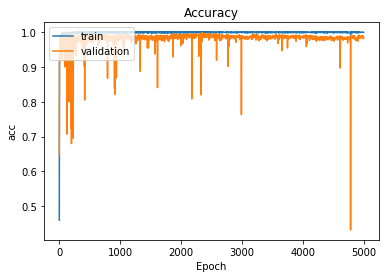

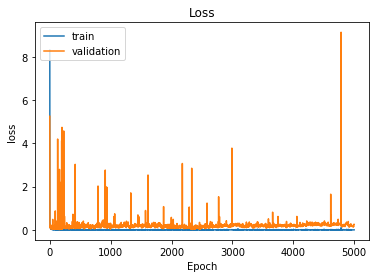

In [9]:
def show_train_history(train_history, title, train, validation):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title(title)
    plt.ylabel(train)
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc = 'upper left')
    plt.show()

show_train_history(train_history, 'Accuracy', 'acc', 'val_acc')
show_train_history(train_history, 'Loss', 'loss', 'val_loss')

In [10]:
scores = model.evaluate(x_test,y_test_onehot)
print()
print('accuracy=',scores[1])

687/687 [==============================] - 0s 402us/step

accuracy= 0.9883551673944687


In [11]:
import pandas as pd
pose = [{"姿勢":"仰臥"},{"姿勢":"俯臥"},{"姿勢":"右側"},{"姿勢":"左側"},{"姿勢":"坐姿"}]
pose_df = pd.DataFrame(pose)

prediction = model.predict_classes(x_test)
pred = pd.crosstab(y_test, prediction, rownames=['label'], colnames=['predict'])

com = pd.concat([pose_df, pred], axis = 1)
com

,姿勢,0,1,2,3,4
0,仰臥,182,0,2,0,0
1,俯臥,0,260,0,0,0
2,右側,0,0,107,6,0
3,左側,0,0,0,113,0
4,坐姿,0,0,0,0,17


In [12]:
model.save('Models/7x9/7x9model.h5')

In [13]:
model.save_weights('Models/7x9/7x9model_weights.h5')

In [14]:
from tensorflow.contrib import lite
converter = tf.lite.TFLiteConverter.from_keras_model_file('Models/7x9/7x9model.h5')
tfmodel = converter.convert()
open ('Models/7x9/7x9model.tflite' , "wb") .write(tfmodel)

ImportError: cannot import name 'lite'